In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [3]:
#Loading the DataSet
data = pd.read_csv('/content/drive/MyDrive/timeseries_sales(in).csv')

**1.DATA PREPARATION**

***1.1 Analysing the Dataset***


In [4]:
# Getting first five rows of the Dataset
data.head(5)

order_id  order_date   ship_date       ship_mode customer_id  \
0  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
1  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
2  CA-2017-138688   12/6/2017    16/06/17    Second Class    DV-13045   
3  US-2016-108966  11/10/2016    18/10/16  Standard Class    SO-20335   
4  US-2016-108966  11/10/2016    18/10/16  Standard Class    SO-20335   

         country             city       state  postal_code region  \
0  United States        Henderson    Kentucky      42420.0  South   
1  United States        Henderson    Kentucky      42420.0  South   
2  United States      Los Angeles  California      90036.0   West   
3  United States  Fort Lauderdale     Florida      33311.0  South   
4  United States  Fort Lauderdale     Florida      33311.0  South   

        product_id         category sub_category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454        Furniture       Chairs   
2  OFF-LA-10000240  Office Supplies       Labels   
3  FUR-TA-10000577        Furniture       Tables   
4  OFF-ST-10000760  Office Supplies      Storage   

                                        product_name   sales_$  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [5]:
data.shape

(9800, 15)

In [6]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      9800 non-null   object 
 1   order_date    9800 non-null   object 
 2   ship_date     9800 non-null   object 
 3   ship_mode     9800 non-null   object 
 4   customer_id   9800 non-null   object 
 5   country       9800 non-null   object 
 6   city          9800 non-null   object 
 7   state         9800 non-null   object 
 8   postal_code   9789 non-null   float64
 9   region        9800 non-null   object 
 10  product_id    9800 non-null   object 
 11  category      9800 non-null   object 
 12  sub_category  9800 non-null   object 
 13  product_name  9800 non-null   object 
 14  sales_$       9800 non-null   float64
dtypes: float64(2), object(13)
memory usage: 1.1+ MB
None


In [7]:
# Getting the count of unique values for each column in the dataset
unique_counts = data.nunique()
print(unique_counts)


order_id        4922
order_date      1230
ship_date       1326
ship_mode          4
customer_id      793
country            1
city             529
state             49
postal_code      626
region             4
product_id      1861
category           3
sub_category      17
product_name    1849
sales_$         5757
dtype: int64


In [8]:
# Calculating the mean and median for the sales_$ column
mean_sales = data['sales_$'].mean()
median_sales = data['sales_$'].median()
print(f"Mean Sales: {mean_sales}")
print(f"Median Sales: {median_sales}")


Mean Sales: 230.7690594591837
Median Sales: 54.489999999999995


In [9]:
data.isnull().sum()

order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
country          0
city             0
state            0
postal_code     11
region           0
product_id       0
category         0
sub_category     0
product_name     0
sales_$          0
dtype: int64

In [10]:
# Handling null values
# Replacing the null values in postal_code column with the mode of the same column
data['postal_code'].fillna(data['postal_code'].mode()[0], inplace=True)

In [11]:
print(data.isnull().sum())

order_id        0
order_date      0
ship_date       0
ship_mode       0
customer_id     0
country         0
city            0
state           0
postal_code     0
region          0
product_id      0
category        0
sub_category    0
product_name    0
sales_$         0
dtype: int64


In [12]:
# Date Format Conversion and Validation
# Function to convert date format from %d/%m/%y to %d-%m-%Y
def convert_date_format(date_str):
    try:
        # Check if date is in %d/%m/%y format
        date_obj = pd.to_datetime(date_str, format='%d/%m/%y', errors='coerce')
        if pd.notna(date_obj):
            return date_obj.strftime('%d-%m-%Y')
        else:
            # If parsing fails, try another format
            return pd.to_datetime(date_str, format='%d-%m-%Y', errors='coerce').strftime('%d-%m-%Y')
    except ValueError:
        return date_str

# Apply the function to 'order_date' and 'ship_date' columns
data['order_date'] = data['order_date'].apply(convert_date_format)
data['ship_date'] = data['ship_date'].apply(convert_date_format)

# Convert the columns to datetime format
data['order_date'] = pd.to_datetime(data['order_date'], format='%d-%m-%Y', errors='coerce')
data['ship_date'] = pd.to_datetime(data['ship_date'], format='%d-%m-%Y', errors='coerce')


In [13]:
#Extracting Date Features from order_date
data['day'] = data['order_date'].dt.day
data['month'] = data['order_date'].dt.month
data['year'] = data['order_date'].dt.year
data['day_of_week'] = data['order_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

***1.2 Handling Outliers***



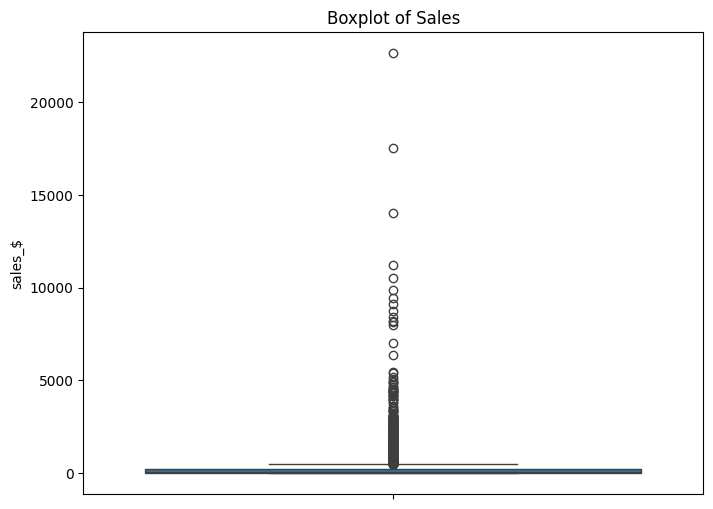

In [14]:
# Visualizing Sales Data with a Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y='sales_$', data=data)
plt.title('Boxplot of Sales')
plt.ylabel('sales_$')
plt.show()

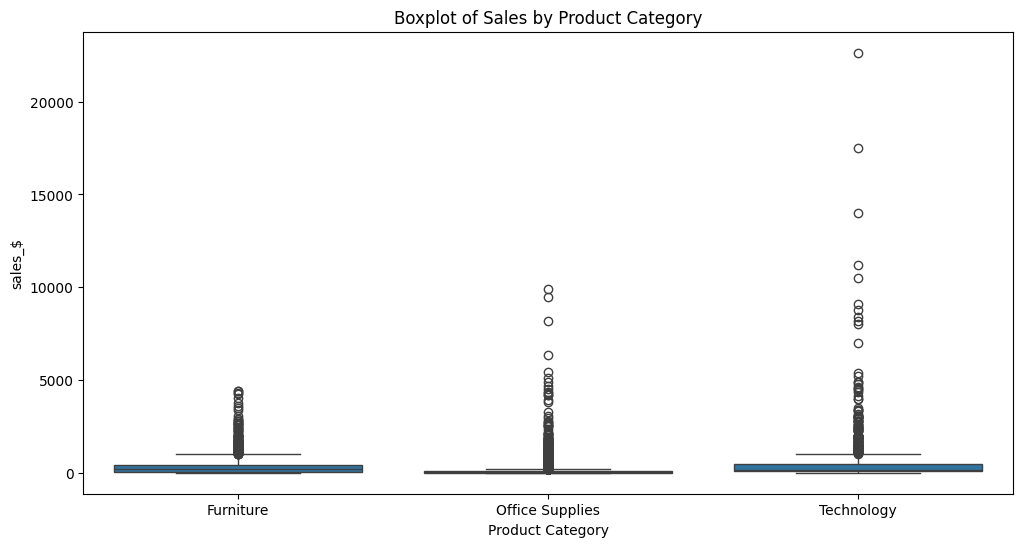

In [15]:
# Visualizing a boxplot for sales grouped by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='sales_$', data=data)
plt.title('Boxplot of Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('sales_$')
plt.show()


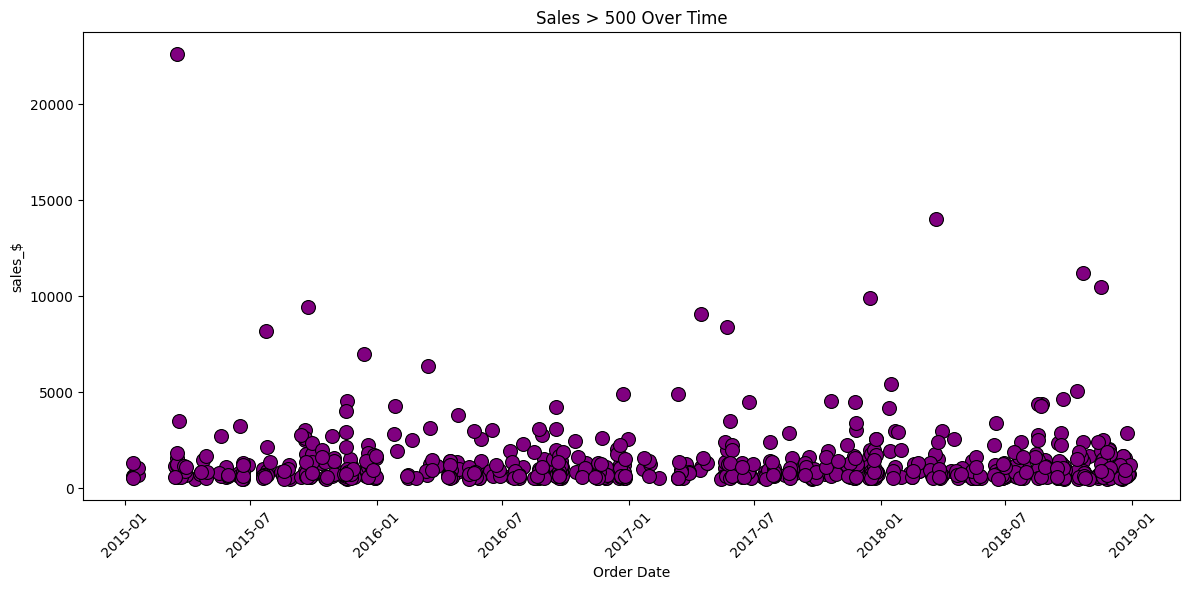

In [16]:
# Filtering sales values greater than 500
high_sales = data[data['sales_$'] > 500]

# Plotting the sales values greater than 500 against order_date
plt.figure(figsize=(12, 6))
sns.scatterplot(x='order_date', y='sales_$', data=high_sales, color='purple', s=100, edgecolor='black')

plt.title('Sales > 500 Over Time')
plt.xlabel('Order Date')
plt.ylabel('sales_$')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# Calculating the 99th percentile for the sales_$ column
percentile_99 = data['sales_$'].quantile(0.99)

# Filtering the data to remove values above the 99th percentile
cleaned_data = data[data['sales_$'] <= percentile_99]
print(f"99th Percentile of Sales: {percentile_99}")
print(f"Number of rows after removing values above the 99th percentile: {cleaned_data.shape[0]}")


99th Percentile of Sales: 2480.2078000000056
Number of rows after removing values above the 99th percentile: 9702


In [18]:
# Analyzing the removed rows
filtered_data = data[~data.index.isin(cleaned_data.index)]
print(filtered_data['sales_$'].describe())


count       98.000000
mean      4559.617449
std       3167.368525
min       2504.740000
25%       2800.950000
50%       3405.582000
75%       4620.052500
max      22638.480000
Name: sales_$, dtype: float64


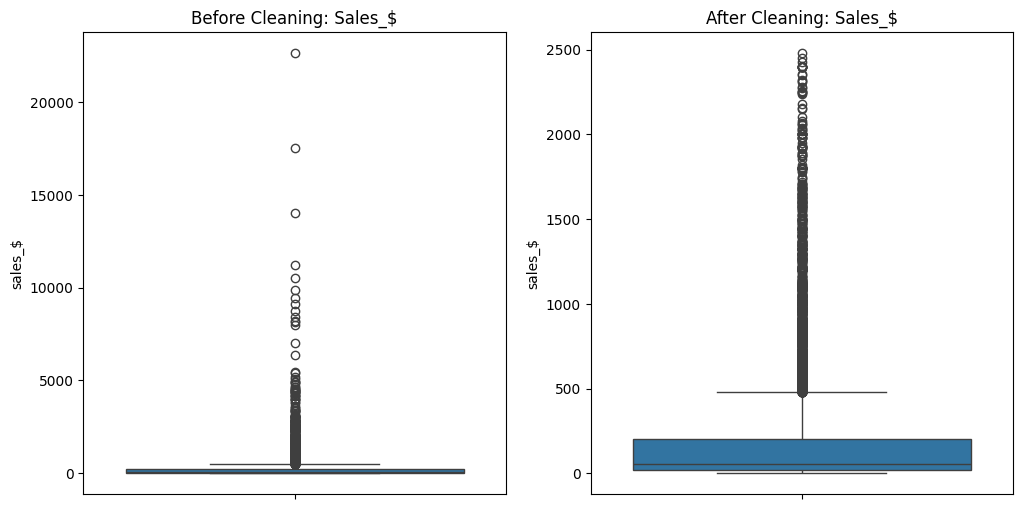

In [19]:
# Plotting before cleaning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data['sales_$'])
plt.title('Before Cleaning: Sales_$')
# Plotting after cleaning
plt.subplot(1, 2, 2)
sns.boxplot(cleaned_data['sales_$'])
plt.title('After Cleaning: Sales_$')
plt.show()


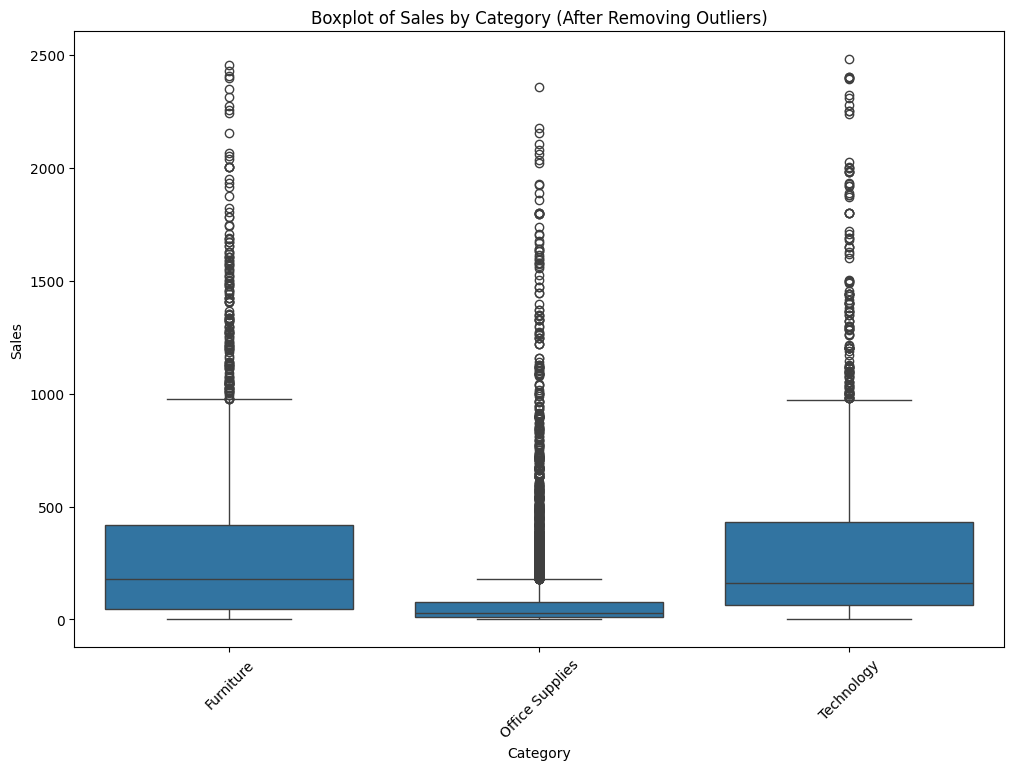

In [20]:
# Visualizing the boxplot for log_sales after removing outliers, categorized by 'category'
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='sales_$', data=cleaned_data)
plt.title('Boxplot of Sales by Category (After Removing Outliers)')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [21]:
data=cleaned_data
data.shape

(9702, 20)

**2.EXPLORATORY DATA ANALYSIS(EDA)**


***2.1 Visualizing sales over time***

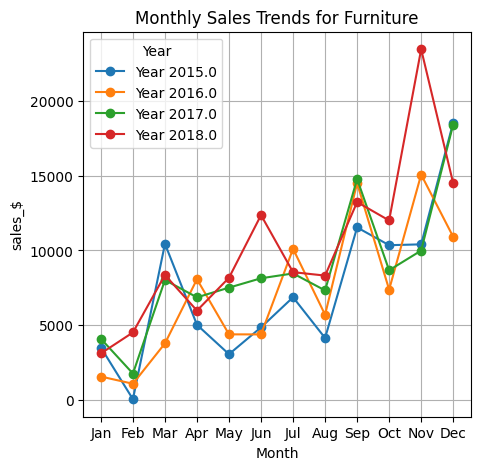

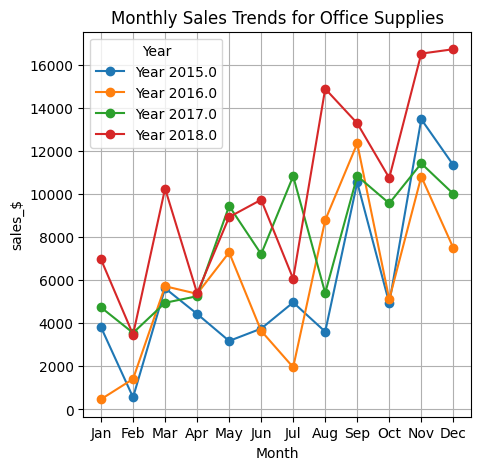

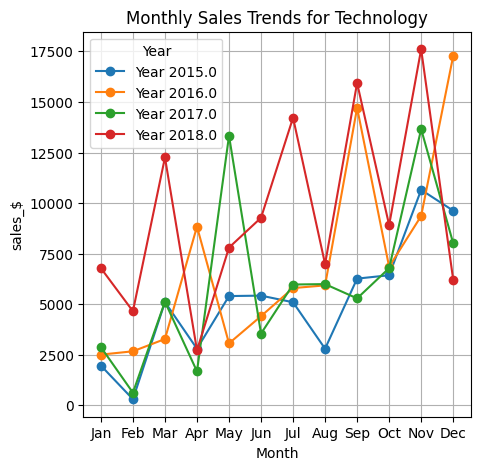

In [22]:
# Visualizing monthly sales of each category over year
# Getting unique categories
categories = data['category'].unique()

# Creating a figure for each category
for cat in categories:
    # Filtering data for the current category
    category_data = data[data['category'] == cat]

    # Aggregating log_sales by year and month
    monthly_sales = category_data.groupby(['year', 'month'])['sales_$'].sum().unstack(level=0)

    # Plotting the data
    plt.figure(figsize=(5, 5))

    # Plotting each year's sales data
    for year in monthly_sales.columns:
        plt.plot(monthly_sales.index, monthly_sales[year], marker='o', label=f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('sales_$')
    plt.title(f'Monthly Sales Trends for {cat}')
    plt.legend(title='Year')
    plt.grid(True)

    # Adjusting x-axis ticks for months
    if isinstance(category_data['month'].iloc[0], str):  # If month is a string
        plt.xticks(monthly_sales.index, monthly_sales.index, rotation=45)
    else:  # If month is numeric
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.show()


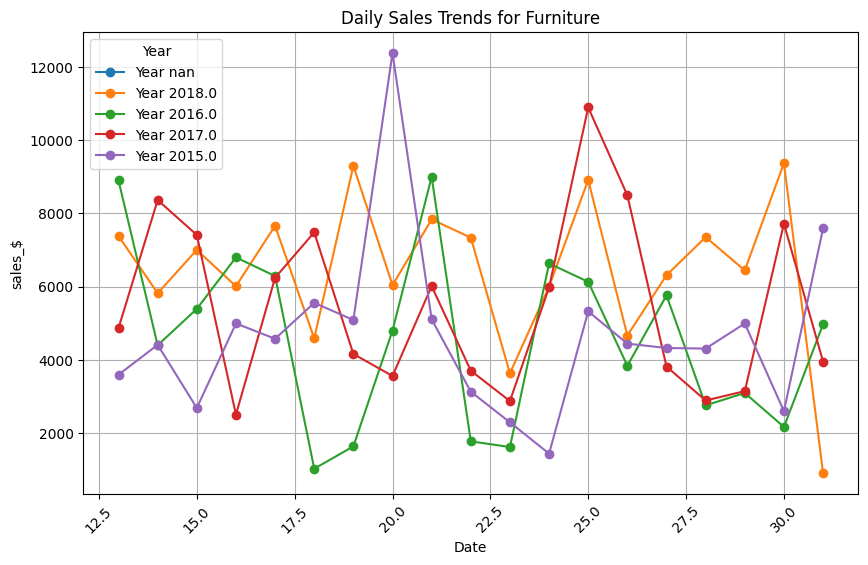

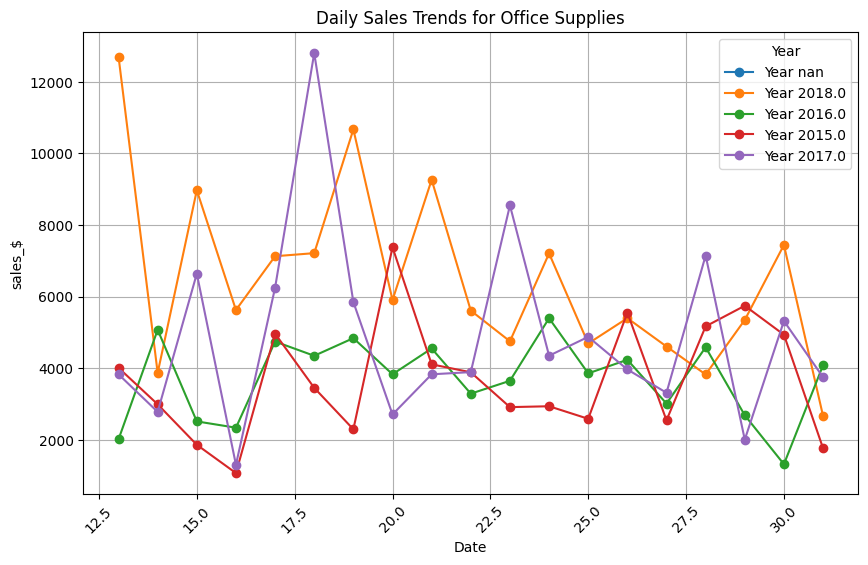

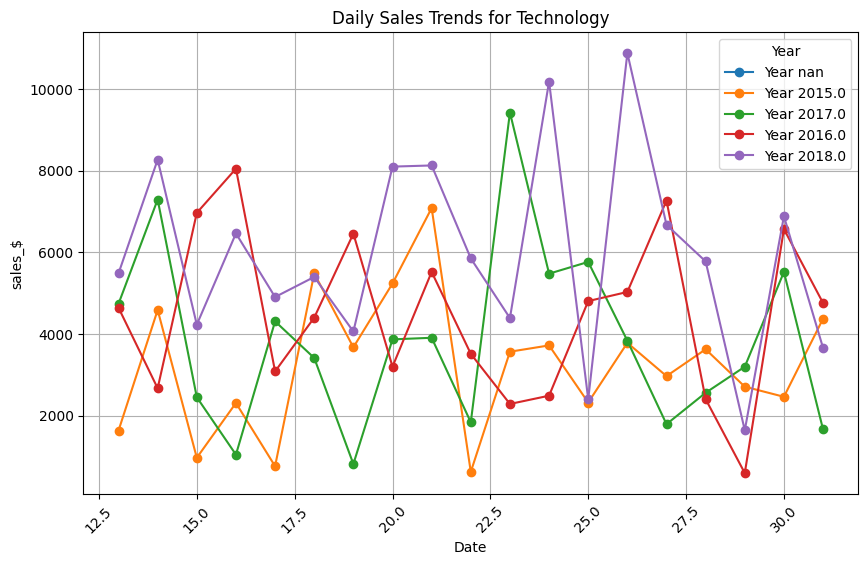

In [23]:
# Visualizing daily sales of each category over year
for cat in categories:
    # Filtering data for the current category
    category_data = data[data['category'] == cat]

    # Getting unique years for the current category
    years = category_data['year'].unique()

    # Creating a plot for the current category
    plt.figure(figsize=(10, 6))

    for year in years:
        # Filter data for the current year
        yearly_data = category_data[category_data['year'] == year]

        # Aggregating log_sales by date
        daily_sales = yearly_data.groupby('day')['sales_$'].sum()

        # Plotting the daily sales data
        plt.plot(daily_sales.index, daily_sales, marker='o', label=f'Year {year}')

    plt.xlabel('Date')
    plt.ylabel('sales_$')
    plt.title(f'Daily Sales Trends for {cat}')
    plt.legend(title='Year')
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.show()

In [24]:
# order_date is set as the index
data['order_date'] = pd.to_datetime(data['order_date'], format='%d-%m-%Y', errors='coerce')
data.set_index('order_date', inplace=True)

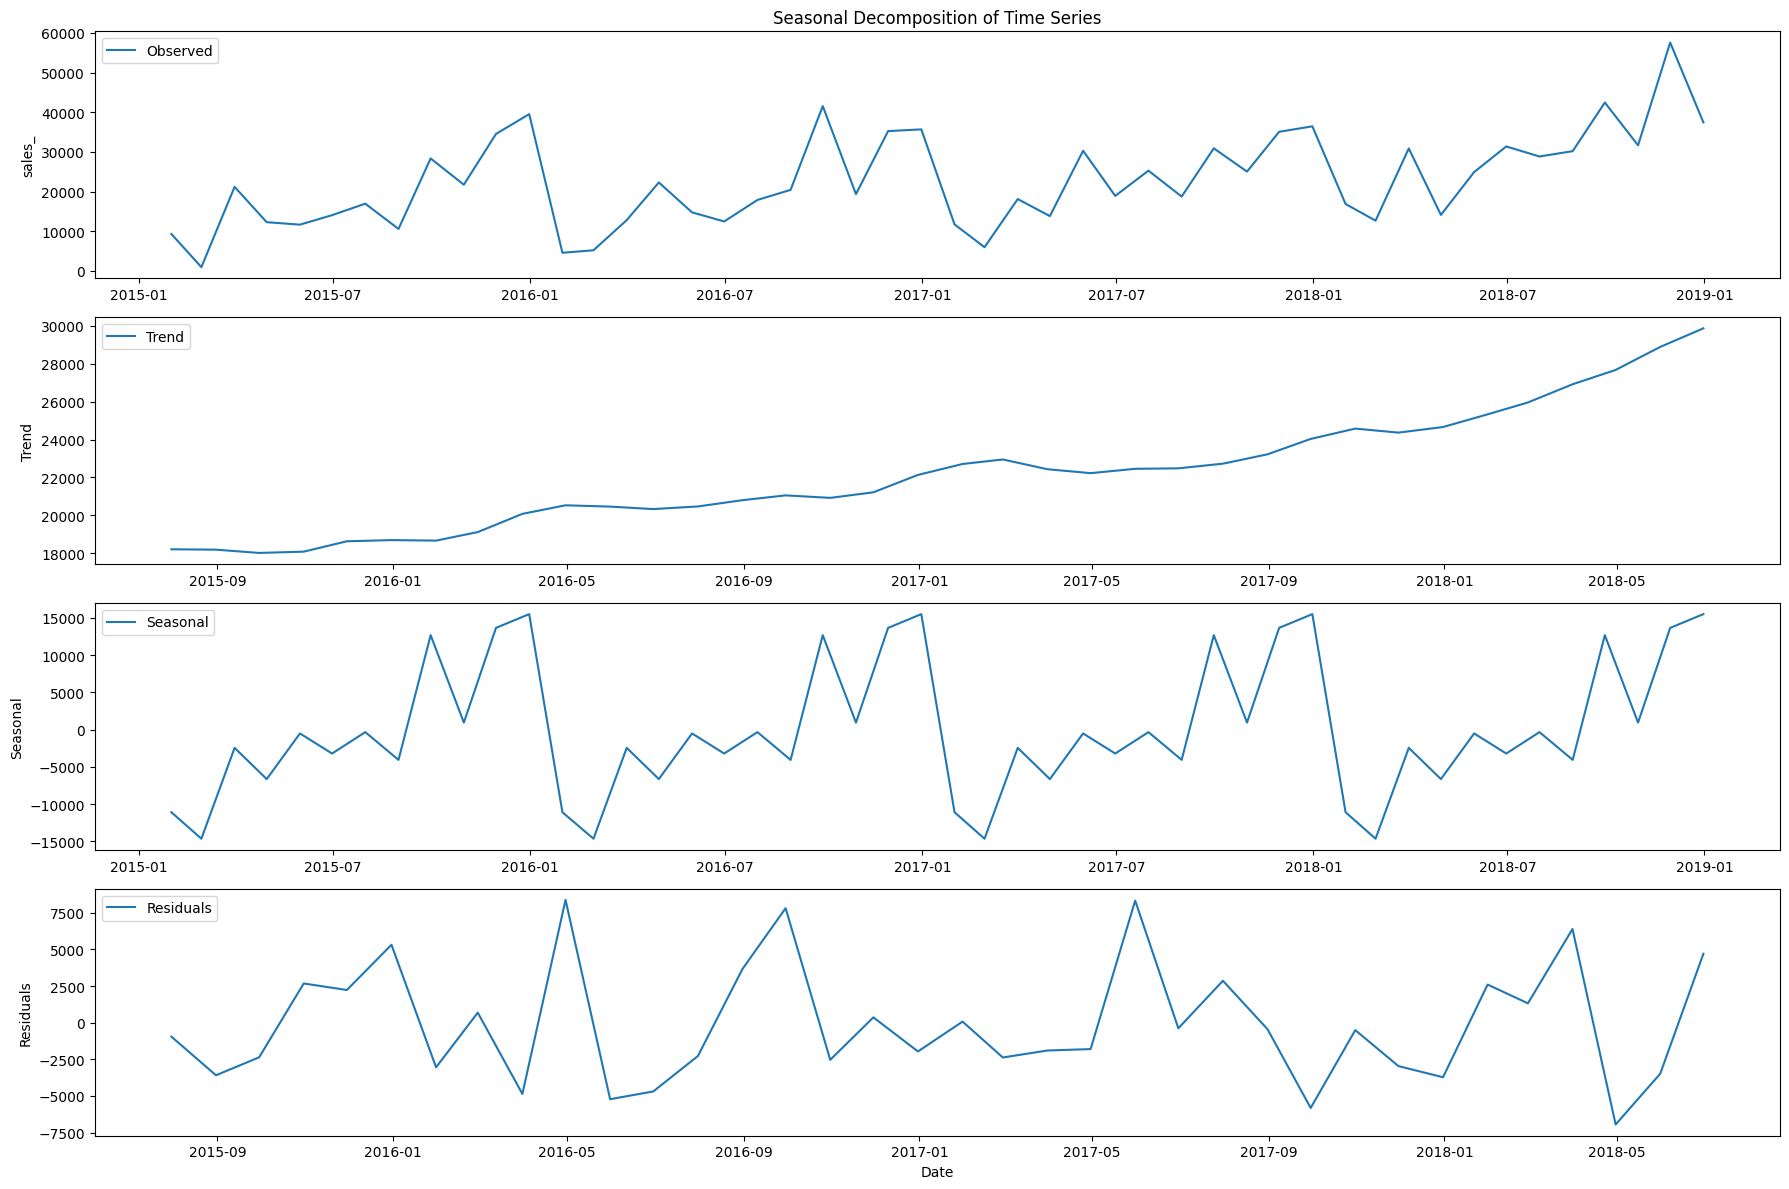

In [25]:
# Seasonal Decomposition
# Resampling the data to ensure consistent frequency
monthly_sales = data['sales_$'].resample('M').sum()
rcParams['figure.figsize'] = 18, 8

# Decomposing the time series
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive', period=12)
# Creating individual plots for each component to ensure visibility
plt.figure(figsize=(18, 12))

# Plotting Observed
plt.subplot(4, 1, 1)
plt.plot(monthly_sales, label='Observed')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition of Time Series')
plt.ylabel('sales_')

# Plotting Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

# Plotting Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

# Plotting Residuals
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.ylabel('Residuals')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


**3.FEATURE ENGINEERING**


***3.1 Aggregating sales over different columns***


In [26]:
# Grouping by order_date, category, sub_category, and state, aggregating both log_sales and sales_$
sales_data = data.groupby(['order_date', 'category', 'sub_category','state'])[['sales_$']].sum().reset_index()


In [27]:
# Extracting month, day, and year from the order_date
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['day'] = sales_data['order_date'].dt.day
sales_data['year'] = sales_data['order_date'].dt.year
sales_data['day_of_week'] = sales_data['order_date'].dt.dayofweek
sales_data['is_weekend'] = sales_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [28]:
sales_data.shape

(5157, 10)

***3.2 Adding additional features***





In [29]:
#Adding lagged features
# Defining the lags in days
lags = [1, 7,15,30,90,180,270,365]

# Creating lagged features for each specified lag (1 day, 7 days, 30 days,365 days)
for lag in lags:
    sales_data[f'sales_lag_{lag}'] = sales_data.groupby('category')['sales_$'].shift(lag)
# Handling NaN values in lagged columns
sales_data.fillna({'sales_lag_1': 0, 'sales_lag_7': 0, 'sales_lag_30': 0, 'sales_lag_365': 0,'sales_lag_15': 0,'sales_lag_30': 0,'sales_lag_180': 0,'sales_lag_270': 0,'sales_lag_90': 0}, inplace=True)

In [30]:
#Adding LFL growth
sales_data['LFL_growth'] = (sales_data['sales_$'] - sales_data['sales_lag_365']) / sales_data['sales_lag_365'] * 100
#Handling NaN and inf values in LFL growth column
sales_data['LFL_growth'] = sales_data['LFL_growth'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [31]:
sales_data['sales_$']

0       333.999
1       545.940
2        19.900
3         5.640
4         3.438
         ...   
5152    209.300
5153     34.624
5154     52.776
5155      3.024
5156     90.930
Name: sales_$, Length: 5157, dtype: float64

In [32]:
# List of moving average windows
windows = [3, 7, 15, 30, 90, 180,270,365]

# Adding moving averages
for window in windows:
    sales_data[f'moving_avg_{window}'] = sales_data.groupby('category')['sales_$'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

# Adding 30-day moving average for the same period last year
sales_data['moving_avg_30_last_year'] = sales_data.groupby('category')['sales_$'].transform(lambda x: x.shift(365).rolling(window=30, min_periods=1).mean())
# Handling NaN values in moving averages columns
moving_avg_columns = [
    'moving_avg_3', 'moving_avg_7', 'moving_avg_15', 'moving_avg_30',
    'moving_avg_90', 'moving_avg_180', 'moving_avg_365', 'moving_avg_270',
    'moving_avg_30_last_year'
]
sales_data[moving_avg_columns] = sales_data[moving_avg_columns].fillna(0)


In [33]:
# Calculating exponential moving average (EMA)
spans = [3, 7, 15, 30, 90, 180,270,365]
for span in spans:
    sales_data[f'ema_{span}'] = sales_data.groupby('category')['sales_$'].transform(
        lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
# Handling NaN values in EMA columns
for span in spans:
    sales_data[f'ema_{span}'].fillna(0, inplace=True)

In [34]:
sales_data['ema_3']

0         0.000000
1       333.999000
2         0.000000
3        19.900000
4        12.770000
           ...    
5152    117.237325
5153    163.268662
5154     98.946331
5155     75.861166
5156    191.162034
Name: ema_3, Length: 5157, dtype: float64

In [35]:
# Adding day of the week indicators
sales_data['day_of_week'] = sales_data['order_date'].dt.dayofweek
sales_data = pd.get_dummies(sales_data, columns=['day_of_week'], prefix='day_of_week', drop_first=True)

# Adding month and day indicators
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['day'] = sales_data['order_date'].dt.day

# Creating holiday indicators (example: using public holidays in the US)
from pandas.tseries.holiday import USFederalHolidayCalendar

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=sales_data['order_date'].min(), end=sales_data['order_date'].max())
sales_data['is_holiday'] = sales_data['order_date'].isin(holidays).astype(int)

# Adding a feature for the start of the month
sales_data['start_of_month'] = (sales_data['order_date'].dt.is_month_start).astype(int)

# Adding a feature for the end of the month
sales_data['end_of_month'] = (sales_data['order_date'].dt.is_month_end).astype(int)

In [36]:
sales_data.isna().sum()

order_date                 0
category                   0
sub_category               0
state                      0
sales_$                    0
month                      0
day                        0
year                       0
is_weekend                 0
sales_lag_1                0
sales_lag_7                0
sales_lag_15               0
sales_lag_30               0
sales_lag_90               0
sales_lag_180              0
sales_lag_270              0
sales_lag_365              0
LFL_growth                 0
moving_avg_3               0
moving_avg_7               0
moving_avg_15              0
moving_avg_30              0
moving_avg_90              0
moving_avg_180             0
moving_avg_270             0
moving_avg_365             0
moving_avg_30_last_year    0
ema_3                      0
ema_7                      0
ema_15                     0
ema_30                     0
ema_90                     0
ema_180                    0
ema_270                    0
ema_365                    0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
is_holiday                 0
start_of_month             0
end_of_month               0
dtype: int64

In [37]:
sales_data.head(5)

order_date         category sub_category           state  sales_$  month  \
0 2015-01-13        Furniture    Bookcases      California  333.999      1   
1 2015-01-13        Furniture       Chairs  South Carolina  545.940      1   
2 2015-01-13  Office Supplies          Art      California   19.900      1   
3 2015-01-13  Office Supplies      Binders       Louisiana    5.640      1   
4 2015-01-13  Office Supplies      Binders            Ohio    3.438      1   

   day  year  is_weekend  sales_lag_1  ...     ema_365  day_of_week_1  \
0   13  2015           0        0.000  ...    0.000000           True   
1   13  2015           0      333.999  ...  333.999000           True   
2   13  2015           0        0.000  ...    0.000000           True   
3   13  2015           0       19.900  ...   19.900000           True   
4   13  2015           0        5.640  ...   19.822077           True   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   is_holiday  start_of_month  end_of_month  
0           0               0             0  
1           0               0             0  
2           0               0             0  
3           0               0             0  
4           0               0             0  

[5 rows x 44 columns]

***3.3 Feature Importance***




In [38]:
# Creating a label encoder object
label_encoder = LabelEncoder()
# Applying label encoding to categorical columns
sales_data['category'] = label_encoder.fit_transform(sales_data['category'])
sales_data['state'] = label_encoder.fit_transform(sales_data['state'])
sales_data['sub_category'] = label_encoder.fit_transform(sales_data['sub_category'])

In [39]:
# Computing the correlation matrix
correlation_matrix = sales_data.corr()
# Extracting the correlation of each column with 'sales'
correlation_with_sales = correlation_matrix['sales_$']
# Printing the correlations
print(correlation_with_sales)

order_date                -0.005277
category                  -0.021781
sub_category               0.103209
state                     -0.000313
sales_$                    1.000000
month                      0.027474
day                        0.007400
year                      -0.012102
is_weekend                -0.011789
sales_lag_1                0.119898
sales_lag_7                0.128150
sales_lag_15               0.093881
sales_lag_30               0.096375
sales_lag_90               0.079004
sales_lag_180              0.087931
sales_lag_270              0.052029
sales_lag_365              0.066069
LFL_growth                 0.349033
moving_avg_3               0.159165
moving_avg_7               0.206967
moving_avg_15              0.253835
moving_avg_30              0.277925
moving_avg_90              0.306527
moving_avg_180             0.315476
moving_avg_270             0.317650
moving_avg_365             0.319030
moving_avg_30_last_year    0.137795
ema_3                      0

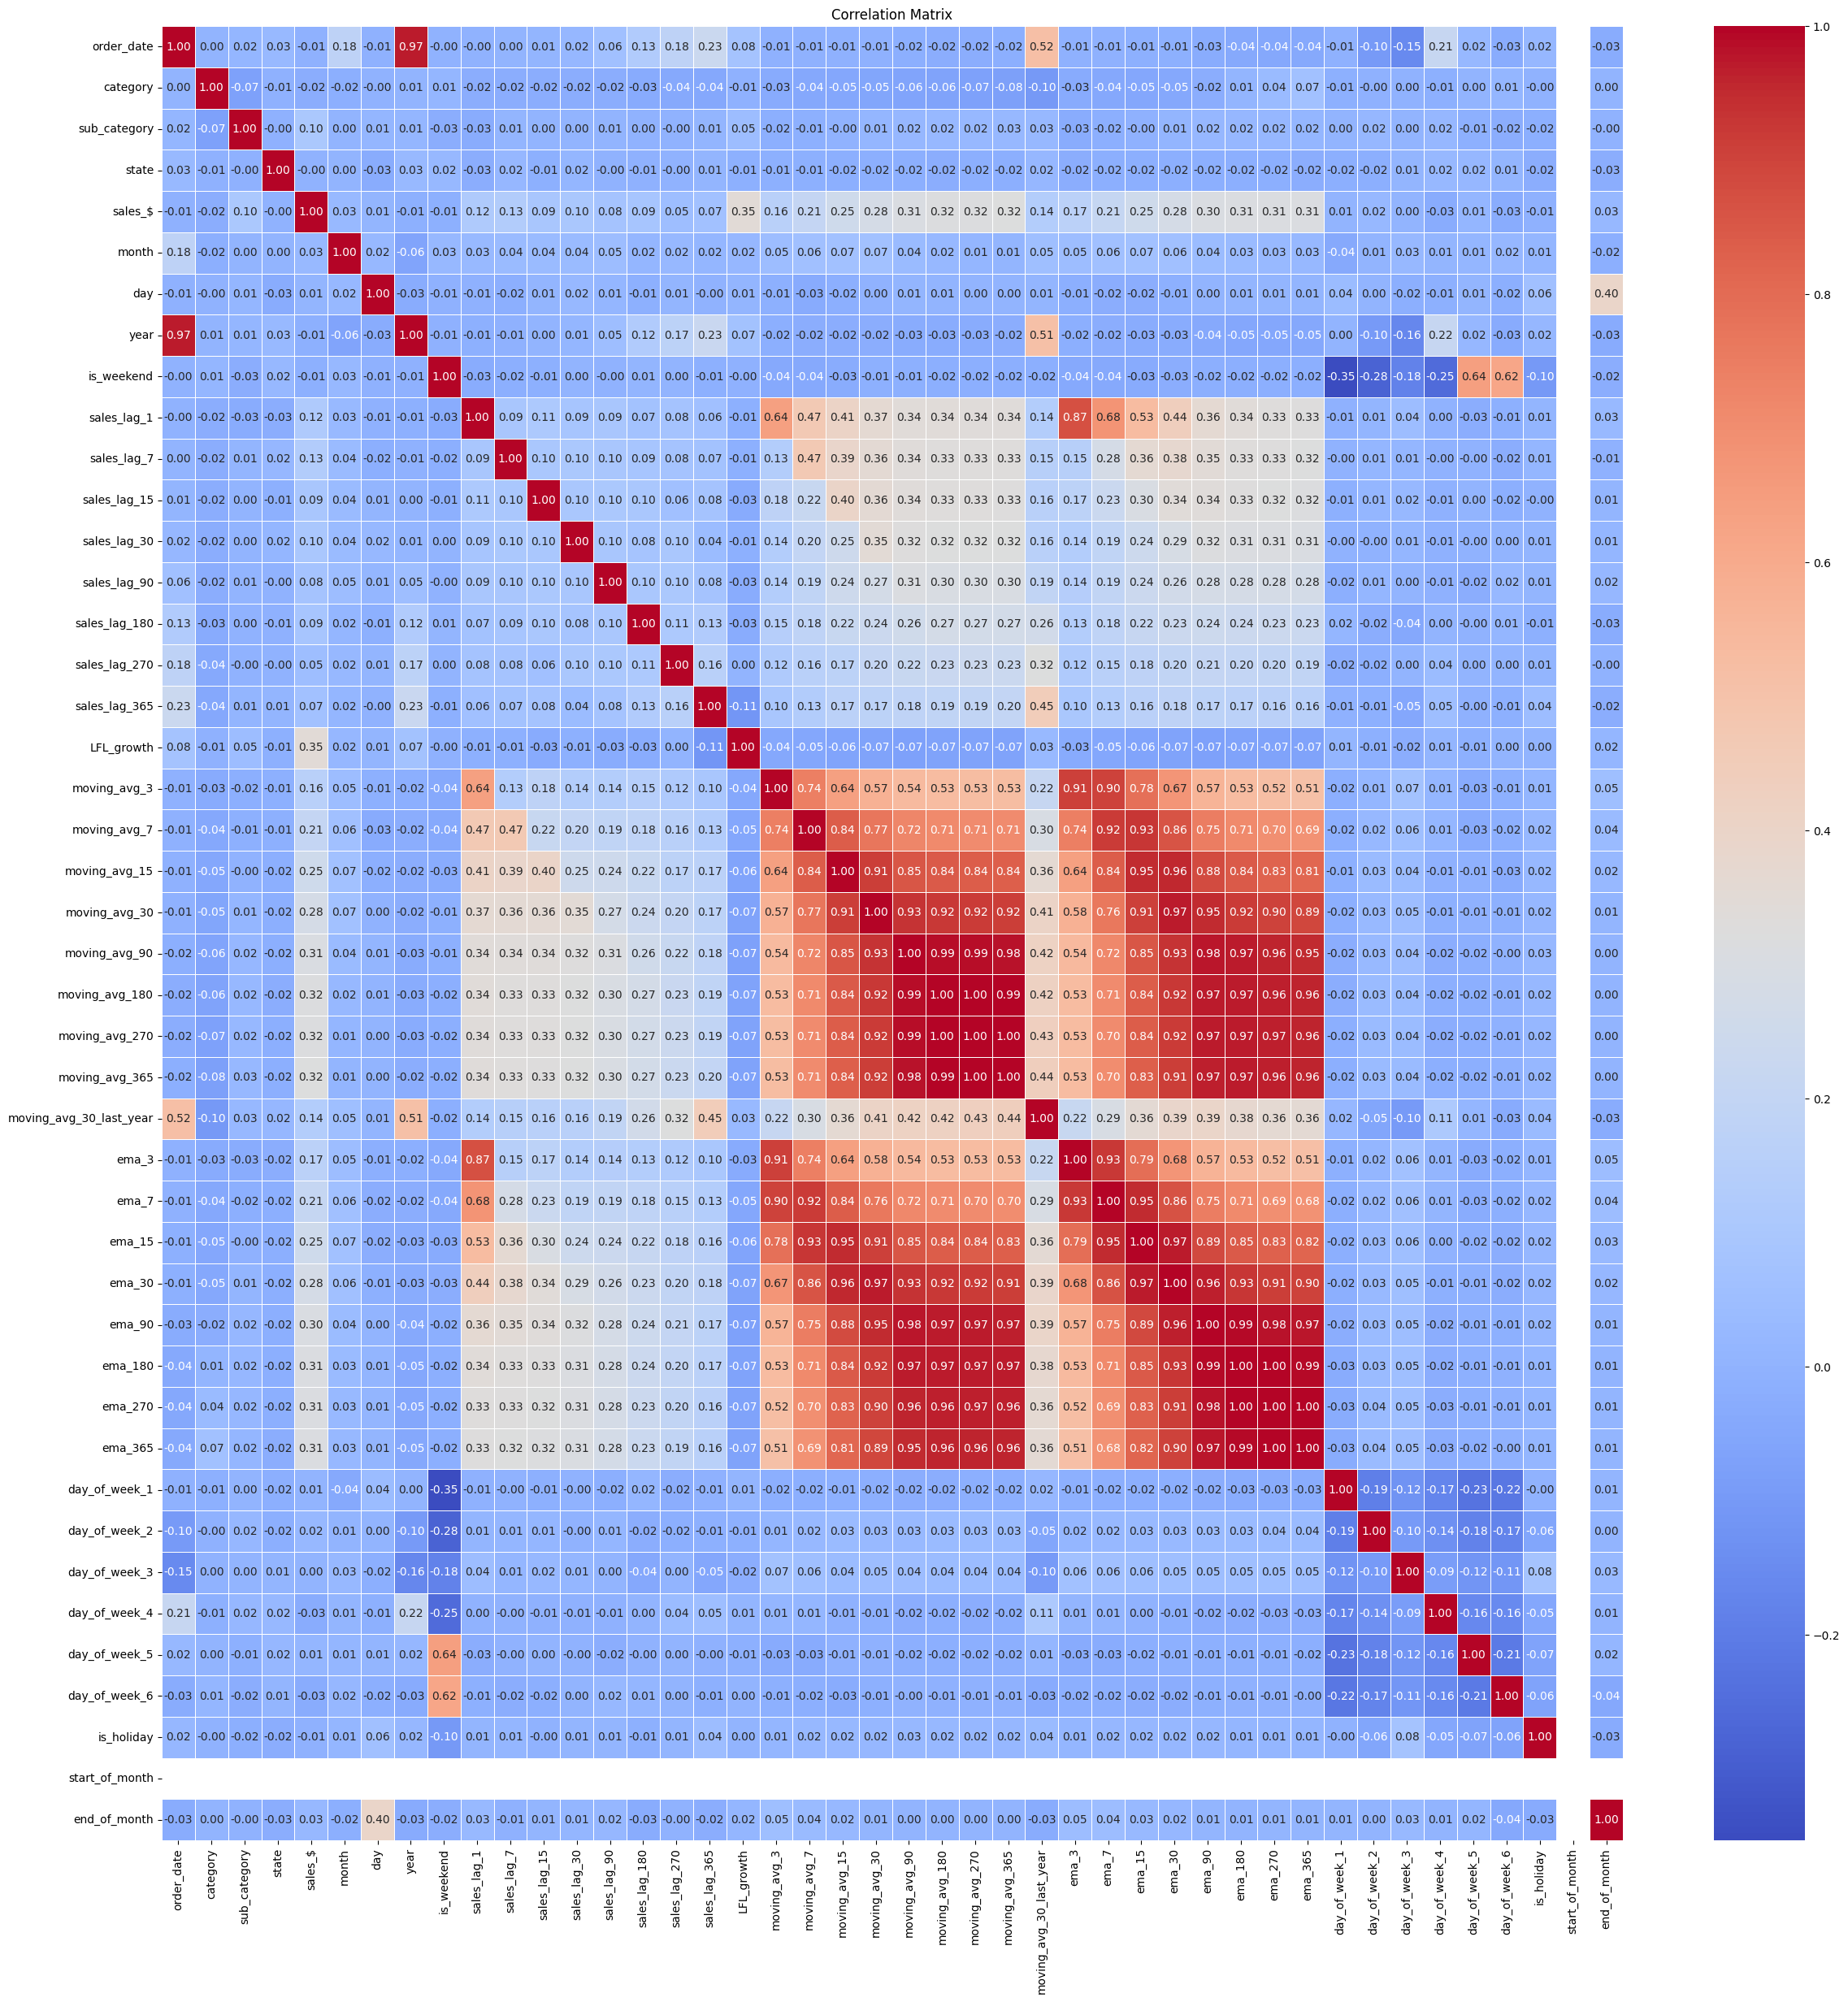

In [40]:
#Visualizing correlation matrix
correlation_matrix = sales_data.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(29, 29))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [41]:
# Checking for infinite values in the DataFrame
inf_counts = np.isinf(sales_data).sum()
print(inf_counts)


order_date                 0
category                   0
sub_category               0
state                      0
sales_$                    0
month                      0
day                        0
year                       0
is_weekend                 0
sales_lag_1                0
sales_lag_7                0
sales_lag_15               0
sales_lag_30               0
sales_lag_90               0
sales_lag_180              0
sales_lag_270              0
sales_lag_365              0
LFL_growth                 0
moving_avg_3               0
moving_avg_7               0
moving_avg_15              0
moving_avg_30              0
moving_avg_90              0
moving_avg_180             0
moving_avg_270             0
moving_avg_365             0
moving_avg_30_last_year    0
ema_3                      0
ema_7                      0
ema_15                     0
ema_30                     0
ema_90                     0
ema_180                    0
ema_270                    0
ema_365       

In [42]:
columns = ', '.join(sales_data.columns)
print(columns)


order_date, category, sub_category, state, sales_$, month, day, year, is_weekend, sales_lag_1, sales_lag_7, sales_lag_15, sales_lag_30, sales_lag_90, sales_lag_180, sales_lag_270, sales_lag_365, LFL_growth, moving_avg_3, moving_avg_7, moving_avg_15, moving_avg_30, moving_avg_90, moving_avg_180, moving_avg_270, moving_avg_365, moving_avg_30_last_year, ema_3, ema_7, ema_15, ema_30, ema_90, ema_180, ema_270, ema_365, day_of_week_1, day_of_week_2, day_of_week_3, day_of_week_4, day_of_week_5, day_of_week_6, is_holiday, start_of_month, end_of_month


In [43]:
# Feature Selection Using PCA
features = features = [ 'category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend',
           'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180',
           'sales_lag_270', 'sales_lag_365', 'LFL_growth', 'moving_avg_3', 'moving_avg_7', 'moving_avg_15',
           'moving_avg_30', 'moving_avg_90', 'moving_avg_180', 'moving_avg_270', 'moving_avg_365',
           'moving_avg_30_last_year', 'ema_3', 'ema_7', 'ema_15', 'ema_30', 'ema_90', 'ema_180', 'ema_270',
           'ema_365', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
           'day_of_week_6', 'is_holiday', 'start_of_month', 'end_of_month'
]


# Extracting features from sales_data
X = sales_data[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=len(features))
pca.fit(X_scaled)

# Creating a DataFrame to store explained variance
explained_variance = pd.Series(pca.explained_variance_ratio_, index=features)

# Getting top features based on explained variance
top_10_features = explained_variance.nlargest(15).index.tolist()
top_5_features = explained_variance.nlargest(5).index.tolist()

print("Top 10 Features:")
print(top_10_features)

print("\nTop 5 Features:")
print(top_5_features)

print("\nExplained Variance Ratio:")
print(explained_variance)


Top 10 Features:
['category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180', 'sales_lag_270']

Top 5 Features:
['category', 'sub_category', 'state', 'sales_$', 'month']

Explained Variance Ratio:
category                   3.454760e-01
sub_category               5.493622e-02
state                      5.093598e-02
sales_$                    4.585857e-02
month                      3.403361e-02
day                        3.216005e-02
year                       2.901266e-02
is_weekend                 2.869338e-02
sales_lag_1                2.745313e-02
sales_lag_7                2.655767e-02
sales_lag_15               2.528946e-02
sales_lag_30               2.429041e-02
sales_lag_90               2.362192e-02
sales_lag_180              2.335988e-02
sales_lag_270              2.228695e-02
sales_lag_365              2.189623e-02
LFL_growth                 2.183182e-02
mo

 **4.MODEL BUILDING**

***4.1 XgBoost***

*4.1.1 Applying XgBoost for sales_data*

In [44]:
split_date = '2018-09-01'
# Splitting the data into training and testing sets
train_data = sales_data[sales_data['order_date'] < split_date]
test_data = sales_data[sales_data['order_date'] >= split_date]


In [45]:
# Converting the DataFrame to NumPy arrays
train = train_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test = test_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX, trainy = train[:, :-1], train[:, -1]
testX, testy = test[:, :-1], test[:, -1]

In [46]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)

# Train the model
model.fit(trainX, trainy)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
# Make predictions on the test set
y_pred = model.predict(testX)
mae = mean_absolute_error(testy, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy, y_pred, squared=False)
print(f" RMSE: {rmse}")

Mean Absolute Error (MAE): 57.523258827653436
 RMSE: 119.11135312300684


In [48]:
# Get feature importance
importance = model.feature_importances_

# List of features
features = ['category', 'sub_category', 'state', 'sales_$', 'month', 'day', 'year', 'is_weekend',
           'sales_lag_1', 'sales_lag_7', 'sales_lag_15', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180',
           'sales_lag_270', 'sales_lag_365', 'LFL_growth', 'moving_avg_3', 'moving_avg_7', 'moving_avg_15',
           'moving_avg_30', 'moving_avg_90', 'moving_avg_180', 'moving_avg_270', 'moving_avg_365',
           'moving_avg_30_last_year', 'ema_3', 'ema_7', 'ema_15', 'ema_30', 'ema_90', 'ema_180', 'ema_270',
           'ema_365', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
           'day_of_week_6', 'is_holiday', 'start_of_month', 'end_of_month']

# Sort feature importance
sorted_indices = np.argsort(importance)[::-1]

# Print feature importance scores
for i in sorted_indices:
    print(f"{features[i]}: {importance[i]:.4f}")

sales_lag_30: 0.3626
sales_lag_7: 0.2493
sales_lag_90: 0.1005
state: 0.0634
year: 0.0467
month: 0.0327
day: 0.0288
sales_lag_15: 0.0254
is_weekend: 0.0216
sub_category: 0.0209
sales_$: 0.0192
sales_lag_1: 0.0177
category: 0.0075
sales_lag_180: 0.0037


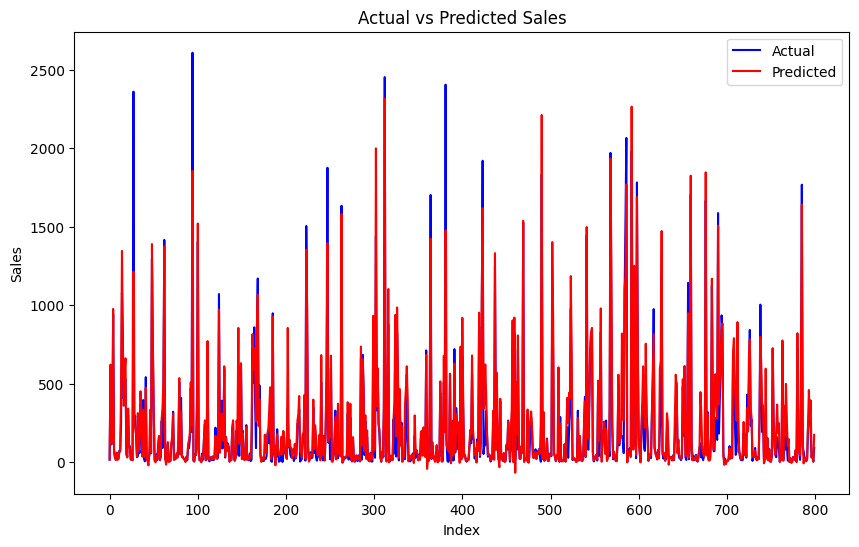

In [49]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(testy, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


(70, 6)


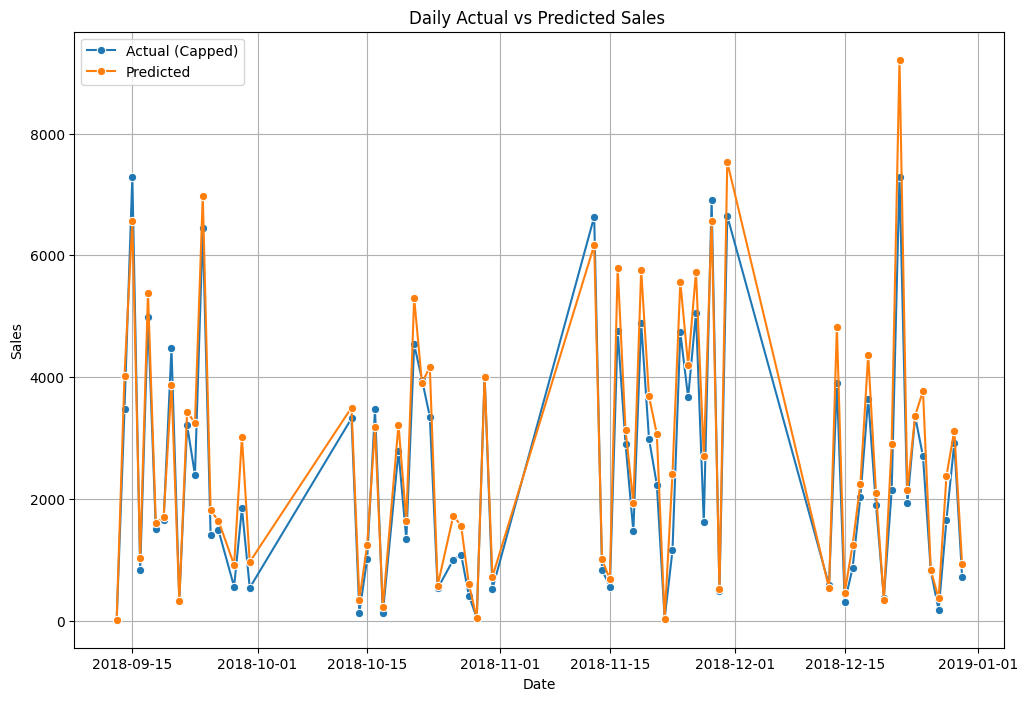

In [50]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data['sales_$'],
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month,
    'day': test_data['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

plt.title('Daily Actual vs Predicted Sales ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Creating separate DataFrames for each category
furniture_df = sales_data[sales_data['category'] == 0]
technology_df = sales_data[sales_data['category'] == 1]
office_df = sales_data[sales_data['category'] == 2]


*4.1.2 Applying XgBoost for Furniture DataSet*

In [52]:
split_date = '2018-09-01'
# Splitting the data into training and testing sets
train_data_f = furniture_df[furniture_df['order_date'] < split_date]
test_data_f = furniture_df[furniture_df['order_date'] >= split_date]


In [53]:
# Converting the DataFrame to NumPy arrays
train_f = train_data_f[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_f = test_data_f[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX_f, trainy_f = train_f[:, :-1], train_f[:, -1]
testX_f, testy_f = test_f[:, :-1],test_f[:, -1]

In [54]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fitting the model using XGBRegressor
furniture_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=8,subsample = 0.8,min_child_weight= 3,colsample_bytree=0.8)

# Training the model
furniture_model.fit(trainX_f, trainy_f)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
# Making predictions on the test set
y_pred_f = furniture_model.predict(testX_f)
mae = mean_absolute_error(testy_f, y_pred_f)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_f, y_pred_f, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 156.2388157318286
 RMSE: 282.5846059884421


(60, 6)


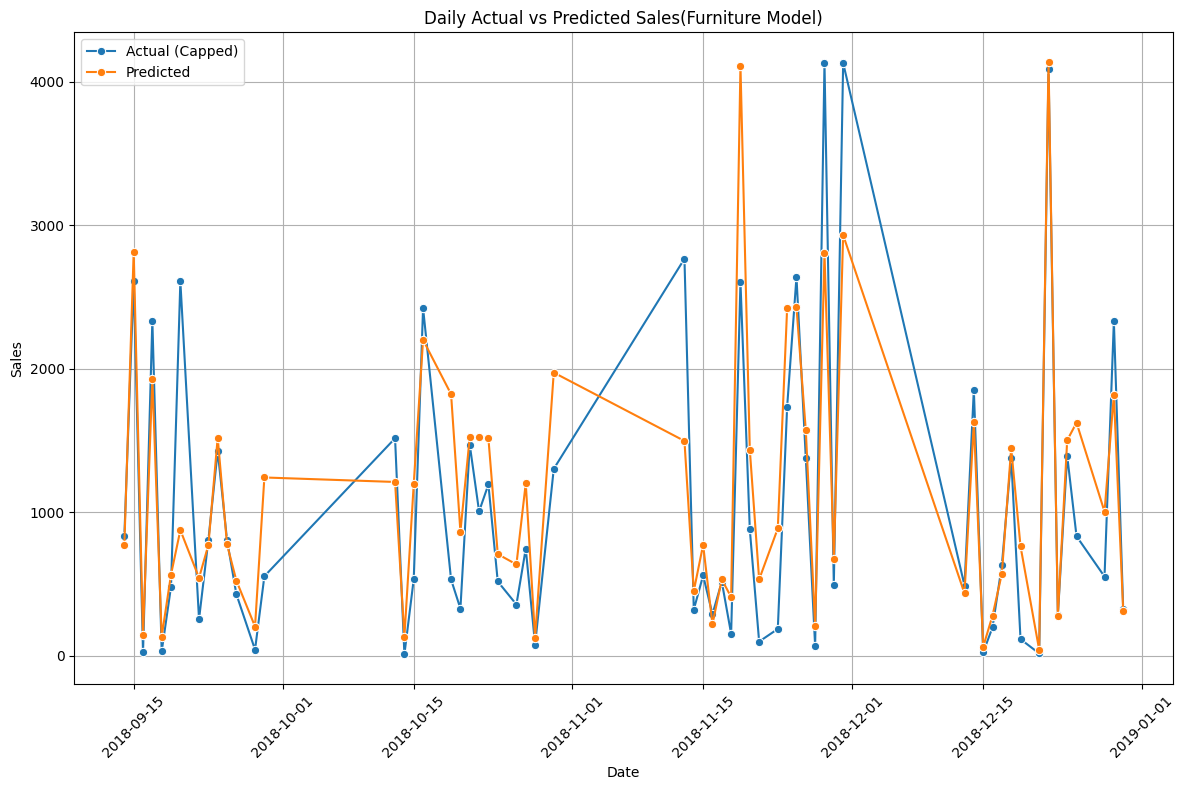

In [56]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_f['sales_$'].values,
    'Predicted': y_pred_f,
    'year': test_data_f['order_date'].dt.year,
    'month': test_data_f['order_date'].dt.month,
    'day': test_data_f['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Furniture Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*4.1.3 Applying XgBoost for Technology DataSet*

In [57]:
split_date = '2018-09-01'

# Split the data into training and testing sets
train_data_t = technology_df[technology_df['order_date'] < split_date]
test_data_t = technology_df[technology_df['order_date'] >= split_date]


In [58]:
# Convert the DataFrame to NumPy arrays
train_t= train_data_t[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_t = test_data_t[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separate the features (X) and target (y) for train and test
trainX_t, trainy_t = train_t[:, :-1], train_t[:, -1]
testX_t, testy_t = test_t[:, :-1], test_t[:, -1]

In [59]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

technology_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=8,subsample = 0.8,min_child_weight= 3,colsample_bytree=0.8)

# Train the model
technology_model.fit(trainX_t, trainy_t)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
# Making predictions on the test set
y_pred_t = technology_model.predict(testX_t)
mae = mean_absolute_error(testy_t, y_pred_t)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_t, y_pred_t, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 24.633802041263937
 RMSE: 82.35008883512646


(68, 6)


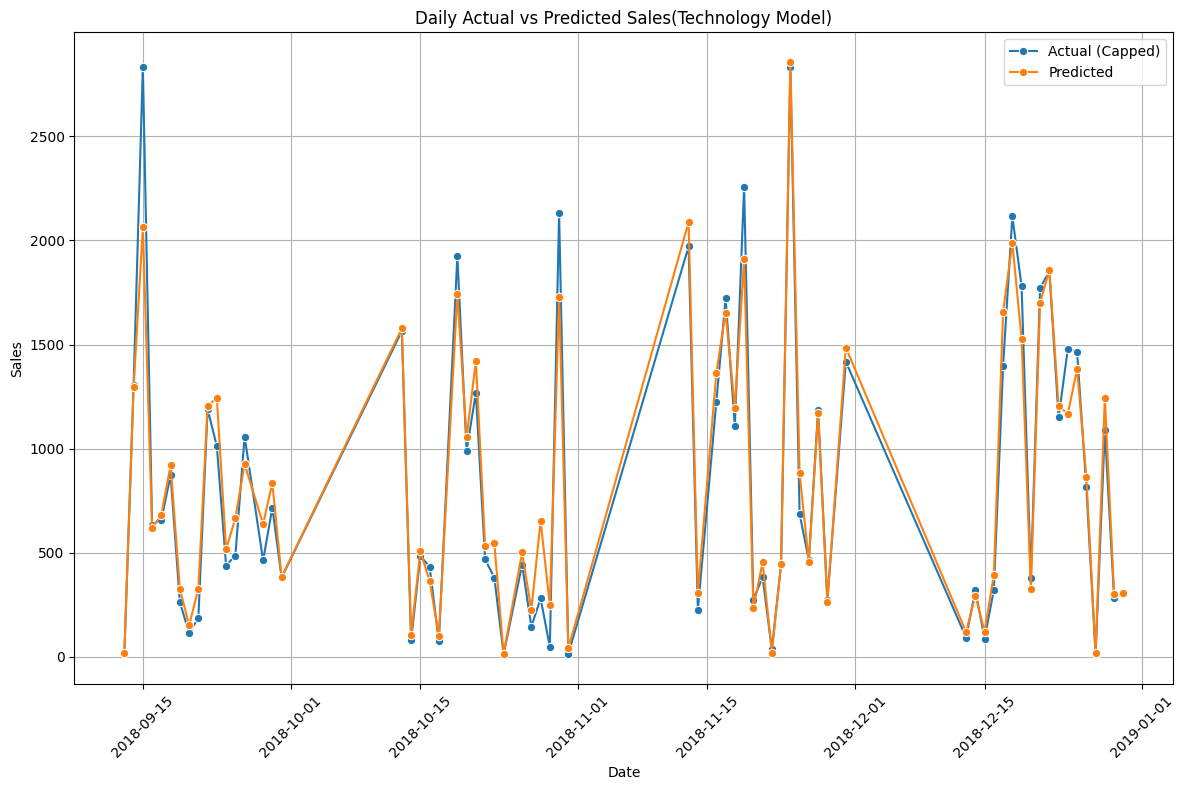

In [61]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_t['sales_$'].values,
    'Predicted': y_pred_t,
    'year': test_data_t['order_date'].dt.year,
    'month': test_data_t['order_date'].dt.month,
    'day': test_data_t['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Technology Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*4.1.3 Applying XgBoost for Office Supplies*

In [62]:
split_date = '2018-09-01'

# Splitting the data into training and testing sets
train_data_o = office_df[office_df['order_date'] < split_date]
test_data_o = office_df[office_df['order_date'] >= split_date]


In [63]:
# Converting the DataFrame to NumPy arrays
train_o= train_data_o[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_o = test_data_o[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separating the features (X) and target (y) for train and test
trainX_o, trainy_o = train_o[:, :-1], train_o[:, -1]
testX_o, testy_o = test_o[:, :-1], test_o[:, -1]

In [64]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fitting the model using XGBRegressor

office_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)

# Training the model
office_model.fit(trainX_o, trainy_o)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
# Making predictions on the test set
y_pred_o = office_model.predict(testX_o)
mae = mean_absolute_error(testy_o, y_pred_o)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_o, y_pred_o, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 248.0226250231236
 RMSE: 306.56665238691505


(57, 6)


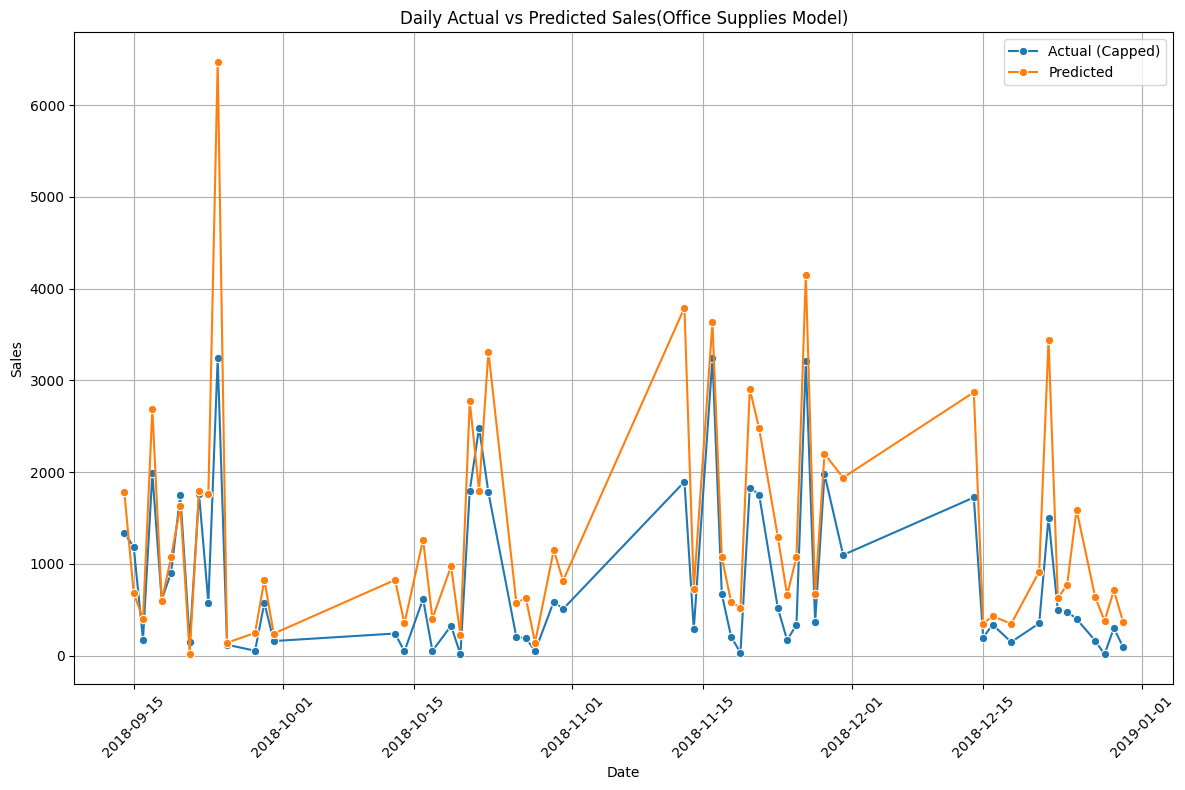

In [66]:
# Creating a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data_o['sales_$'].values,
    'Predicted': y_pred_o,
    'year': test_data_o['order_date'].dt.year,
    'month': test_data_o['order_date'].dt.month,
    'day': test_data_o['order_date'].dt.day
})

# Grouping by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Creating a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Print the shape of the resulting DataFrame (optional)
print(daily_sales.shape)

# Creating a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

# Adding titles, labels, and grid
plt.title('Daily Actual vs Predicted Sales(Office Supplies Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


***4.2 SARIMAX***

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variables
exog_vars = sales_data[['sales_lag_1', 'sales_lag_7', 'sales_lag_30', 'sales_lag_365','moving_avg_3', 'moving_avg_7','LFL_growth'  ,'category','sub_category','state','ema_3','ema_7']]

# Define the SARIMAX model with exogenous variables
model = SARIMAX(sales_data['sales_$'],
                order=(1,1,2),
                exog=exog_vars,
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit()

# Print the summary
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                sales_$   No. Observations:                 5157
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -37070.689
Date:                Tue, 17 Sep 2024   AIC                          74173.377
Time:                        11:28:23   BIC                          74278.135
Sample:                             0   HQIC                         74210.037
                               - 5157                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sales_lag_1       0.2794      0.052      5.383      0.000       0.178       0.381
sales_lag_7       0.0977      0.017      5.647      0.000       0.064       0.132
sales_lag_30      0.0402      0.015     

In [68]:
# Make in-sample predictions
in_sample_pred = model_fit.predict(start=0, end=len(sales_data)-1, exog=exog_vars)


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for in-sample predictions
mae = mean_absolute_error(sales_data['sales_$'], in_sample_pred)
rmse = np.sqrt(mean_squared_error(sales_data['sales_$'], in_sample_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 191.01933322680676
Root Mean Squared Error (RMSE): 318.7933079062374


***4.3 Arima***

In [70]:
split_date = '2018-09-01'
train_data_a = sales_data[sales_data['order_date'] < split_date]
test_data_a = sales_data[sales_data['order_date'] >= split_date]

# Extracting the target variable (log_sales)
train_target = train_data_a['sales_$']
test_target = test_data_a['sales_$']

In [71]:
#Building Arima model
arima_model = ARIMA(train_target, order=(1, 1, 2))
arima_model_fit = model.fit()
print(arima_model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                sales_$   No. Observations:                 5157
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -37070.689
Date:                Tue, 17 Sep 2024   AIC                          74173.377
Time:                        11:29:03   BIC                          74278.135
Sample:                             0   HQIC                         74210.037
                               - 5157                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sales_lag_1       0.2794      0.052      5.383      0.000       0.178       0.381
sales_lag_7       0.0977      0.017      5.647      0.000       0.064       0.132
sales_lag_30      0.0402      0.015     

In [72]:
# Make in-sample predictions on the training data
in_sample_pred_a = arima_model_fit.predict(start=0, end=len(train_data_a)-1)


In [73]:
# Calculate MAE and RMSE for in-sample predictions
mae_in_sample = mean_absolute_error(train_target, in_sample_pred_a)
rmse_in_sample = np.sqrt(mean_squared_error(train_target, in_sample_pred_a))

In [74]:
# Print the error metrics
print(f'Mean Absolute Error (In-Sample): {mae_in_sample}')
print(f'Root Mean Squared Error (In-Sample): {rmse_in_sample}')

Mean Absolute Error (In-Sample): 192.4842421430135
Root Mean Squared Error (In-Sample): 318.4772965868502


**7.FORECASTING**

7.1 *Furniture*

In [76]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

furniture_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)

# Train the model
furniture_model.fit(trainX_f, trainy_f)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
import numpy as np
import pandas as pd

days_to_predict = 90

future_predictions = []

test_df = pd.DataFrame(test_f, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

day_of_week_columns = ['day_of_week_2', 'day_of_week_4']
current_day_of_week = test_df[day_of_week_columns].iloc[-1].idxmax()
day_of_week_map = {'day_of_week_2': 1, 'day_of_week_4': 3}

# Inverse map to convert from day numbers back to column names
inverse_day_of_week_map = {1: 'day_of_week_2', 3: 'day_of_week_4'}  # Update with more mappings if needed

# Identify the current day of the week
current_day_of_week_num = day_of_week_map.get(current_day_of_week, 1)  # Default to 1 (day_of_week_2)

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales
    current_pred = furniture_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Increment the day of the week cyclically (0 to 6)
    current_day_of_week_num = (current_day_of_week_num + 1) % 7

    # Reset all day_of_week columns to 0
    new_row[day_of_week_columns] = 0

    # Set the correct day_of_week column based on the incremented day
    if current_day_of_week_num in inverse_day_of_week_map:
        new_row[inverse_day_of_week_map[current_day_of_week_num]] = 1

    # Append the new row to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")


Next 90-day sales predictions: [ 319.73254 1090.9796  1083.878   1056.2959  1064.1138  1118.522
 1100.6257  1113.0035  1018.3585  1139.5165   994.62537 1011.5371
 1011.83014 1011.83014 1006.1737  1011.82855 1076.7301  1077.2185
 1076.8127  1032.188   1076.8127  1054.4303  1032.188   1005.61926
 1006.1505  1048.6298  1048.6298  1048.2408  1020.25726 1044.3387
 1043.8506  1044.3387  1044.3387  1044.3387  1044.3387  1020.3001
 1044.3387  1043.8506  1044.3387  1044.3387  1044.3387  1044.3387
 1020.3001  1044.3387  1043.8506  1044.3387  1044.3387  1044.3387
 1044.3387  1020.3001  1044.3387  1043.8506  1044.3387  1044.3387
 1044.3387  1044.3387  1020.3001  1044.3387  1043.8506  1044.3387
 1044.3387  1044.3387  1044.3387  1020.3001  1044.3387  1043.8506
 1044.3387  1044.3387  1044.3387  1044.3387  1020.3001  1044.3387
 1043.8506  1044.3387  1044.3387  1044.3387  1044.3387  1020.3001
 1044.3387  1043.8506  1044.3387  1044.3387  1044.3387  1044.3387
 1020.3001  1044.3387  1043.8506  1044.3387  

In [79]:

y_pred_f = furniture_model.predict(testX_f)
mae = mean_absolute_error(testy_f, y_pred_f)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_f, y_pred_f, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 111.2933909098087
 RMSE: 215.47090794331126


*7.2 Technology*

In [99]:
# Convert the DataFrame to NumPy arrays (for consistency with your method)
train_t= train_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test_t = test_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separate the features (X) and target (y) for train and test
trainX_t, trainy_t = train_t[:, :-1], train_t[:, -1]
testX_t, testy_t = test_t[:, :-1], test_t[:, -1]

In [100]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

technology_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=8,subsample = 0.8,min_child_weight= 3,colsample_bytree=0.8)

# Train the model
technology_model.fit(trainX_t, trainy_t)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [101]:
# Make predictions on the test set
y_pred_t = technology_model.predict(testX_t)
mae = mean_absolute_error(testy_t, y_pred_t)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_t, y_pred_t, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 56.31994313877392
 RMSE: 127.66368759731003


In [102]:
import numpy as np
import pandas as pd

# Define number of days to predict
days_to_predict = 90

# Initialize a list to store future predictions
future_predictions = []

# Create a DataFrame from f_test (test set)
test_df = pd.DataFrame(test_f, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

# Define the day_of_week columns you're using
day_of_week_columns = ['day_of_week_2', 'day_of_week_4']  # Add more day_of_week columns if needed

# Map for current day of the week to column name (You can adjust the mapping according to your data)
day_of_week_map = {0: 'day_of_week_2', 3: 'day_of_week_4'}  # Add more mappings if necessary

# Inverse map for easy cycling between day numbers and column names
inverse_day_of_week_map = {v: k for k, v in day_of_week_map.items()}

# Get the current day of the week (from the last row in the DataFrame)
current_day_of_week_col = test_df[day_of_week_columns].iloc[-1].idxmax()
current_day_of_week_num = inverse_day_of_week_map[current_day_of_week_col]  # Find the current day as a number

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales using the technology model
    current_pred = technology_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Increment the day of the week cyclically (using modulo operation for wrap-around)
    current_day_of_week_num = (current_day_of_week_num + 1) % 7

    # Reset all day_of_week columns to 0
    new_row[day_of_week_columns] = 0

    # Set the correct day_of_week column to 1
    if current_day_of_week_num in day_of_week_map:
        new_row[day_of_week_map[current_day_of_week_num]] = 1

    # Append the new row first to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")


Next 90-day sales predictions: [ 309.86502 1035.739   1033.9006  1009.1923   997.87665  979.46234
  993.454   1002.8037  1012.3761  1003.4927   999.66846  998.8227
 1004.32825 1004.65924 1009.41956 1007.1514  1006.7353  1009.17523
 1007.75446 1018.52734 1021.0065  1022.42584 1021.0065  1021.0065
 1026.1321  1023.2997  1024.252   1023.2997  1014.7838  1013.36444
 1013.36444 1014.7851  1013.36444 1013.36444 1013.36444 1014.7838
 1013.36444 1013.36444 1018.64105 1017.2204  1017.2204  1017.2204
 1018.6398  1017.2204  1017.2204  1018.64105 1017.2204  1017.2204
 1017.2204  1018.6398  1017.2204  1017.2204  1018.64105 1017.2204
 1017.2204  1017.2204  1018.6398  1017.2204  1017.2204  1018.64105
 1017.2204  1017.2204  1017.2204  1018.6398  1017.2204  1017.2204
 1018.64105 1017.2204  1017.2204  1017.2204  1018.6398  1017.2204
 1017.2204  1018.64105 1017.2204  1017.2204  1017.2204  1018.6398
 1017.2204  1017.2204  1018.64105 1017.2204  1017.2204  1017.2204
 1018.6398  1017.2204  1017.2204  1018.64

*7.3 Office Supplies*

In [82]:
# Make predictions on the test set
y_pred_o = office_model.predict(testX_o)
mae = mean_absolute_error(testy_o, y_pred_o)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy_o, y_pred_o, squared=False)
print(f" RMSE: {rmse}")


Mean Absolute Error (MAE): 248.0226250231236
 RMSE: 306.56665238691505


In [83]:
import numpy as np
import pandas as pd

# Define number of days to predict
days_to_predict = 90

# Initialize a list to store future predictions
future_predictions = []

# Create a DataFrame from f_test (test set)
test_df = pd.DataFrame(test_o, columns=[
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$'
])

# Define the day_of_week columns you're using
day_of_week_columns = ['day_of_week_2', 'day_of_week_4']  # Add more day_of_week columns if needed

# Map for current day of the week to column name (You can adjust the mapping according to your data)
day_of_week_map = {0: 'day_of_week_2', 3: 'day_of_week_4'}  # Add more mappings if necessary

# Inverse map for easy cycling between day numbers and column names
inverse_day_of_week_map = {v: k for k, v in day_of_week_map.items()}

# Get the current day of the week (from the last row in the DataFrame)
current_day_of_week_col = test_df[day_of_week_columns].iloc[-1].idxmax()
current_day_of_week_num = inverse_day_of_week_map[current_day_of_week_col]  # Find the current day as a number

# Loop over each day to predict iteratively
for day in range(1, days_to_predict + 1):
    # Prepare the data for prediction (use the last row in the test_df as input, excluding target column 'sales_$')
    current_test_data = test_df.iloc[-1, :-1].values  # Exclude 'sales_$' (target)

    # Predict the next day's sales
    current_pred = office_model.predict(current_test_data.reshape(1, -1))[0]

    # Append the prediction to the list of future predictions
    future_predictions.append(current_pred)

    # Create a new row for the predicted day
    new_row = test_df.iloc[-1].copy()
    new_row['sales_$'] = current_pred

    # Increment the day of the week cyclically (using modulo operation for wrap-around)
    current_day_of_week_num = (current_day_of_week_num + 1) % 7

    # Reset all day_of_week columns to 0
    new_row[day_of_week_columns] = 0

    # Set the correct day_of_week column to 1
    if current_day_of_week_num in day_of_week_map:
        new_row[day_of_week_map[current_day_of_week_num]] = 1

    # Append the new row first to allow recalculation of lag features and moving averages after appending
    test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the lag features after appending the new data
    test_df['sales_lag_1'] = test_df['sales_$'].shift(1)
    test_df['sales_lag_365'] = test_df['sales_$'].shift(365) if len(test_df) > 365 else np.nan

    # Recalculate moving averages based on the newly appended data
    test_df['moving_avg_180'] = test_df['sales_$'].rolling(window=180).mean() if len(test_df) >= 180 else np.nan
    test_df['moving_avg_90'] = test_df['sales_$'].rolling(window=90).mean() if len(test_df) >= 90 else np.nan
    test_df['moving_avg_15'] = test_df['sales_$'].rolling(window=15).mean() if len(test_df) >= 15 else np.nan
    test_df['moving_avg_365'] = test_df['sales_$'].rolling(window=365).mean() if len(test_df) >= 365 else np.nan

    # Recalculate exponential moving averages (EMAs) based on the newly appended data
    test_df['ema_3'] = test_df['sales_$'].ewm(span=3).mean() if len(test_df) >= 3 else np.nan
    test_df['ema_15'] = test_df['sales_$'].ewm(span=15).mean() if len(test_df) >= 15 else np.nan
    test_df['ema_180'] = test_df['sales_$'].ewm(span=180).mean() if len(test_df) >= 180 else np.nan

# Convert future_predictions to a NumPy array for further analysis
future_predictions = np.array(future_predictions)

# Output the predictions
print(f"Next 90-day sales predictions: {future_predictions}")


Next 90-day sales predictions: [365.5261  761.0357  449.94458 491.5299  385.9245  359.65268 354.9506
 454.62823 481.25107 470.26437 452.9733  416.57928 478.95984 451.9455
 423.79095 461.95285 492.9575  488.8775  422.82822 428.7646  464.36676
 453.97675 486.30847 445.0554  420.57416 446.88058 433.24902 452.96066
 496.0321  485.08698 428.01028 491.77005 472.9904  432.8354  499.71313
 445.2849  468.861   527.59534 476.19205 463.14688 659.7193  384.05286
 451.63605 479.97467 441.9765  493.24768 427.1417  446.11508 500.62717
 370.55417 308.7714  293.742   317.1471  330.66528 366.69827 295.36423
 398.82648 480.88818 648.8272  677.7647  406.21375 458.51535 445.0296
 469.63565 519.0085  487.5149  746.1     318.98724 626.3071  431.10223
 298.73907 326.76706 378.73785 344.14398 330.35782 297.1605  342.22604
 297.87665 324.94086 272.9559  388.07928 371.29614 300.50452 390.3061
 419.56522 314.52466 401.69724 396.7759  349.38055 288.12057]


**Combined Model**

In [84]:
# Computing the correlation matrix
correlation_matrix = sales_data.corr()
# Extracting the correlation of each column with 'sales'
correlation_with_sales = correlation_matrix['sales_$']
# Printing the correlations
print(correlation_with_sales)


order_date                -0.005277
category                  -0.021781
sub_category               0.103209
state                     -0.000313
sales_$                    1.000000
month                      0.027474
day                        0.007400
year                      -0.012102
is_weekend                -0.011789
sales_lag_1                0.119898
sales_lag_7                0.128150
sales_lag_15               0.093881
sales_lag_30               0.096375
sales_lag_90               0.079004
sales_lag_180              0.087931
sales_lag_270              0.052029
sales_lag_365              0.066069
LFL_growth                 0.349033
moving_avg_3               0.159165
moving_avg_7               0.206967
moving_avg_15              0.253835
moving_avg_30              0.277925
moving_avg_90              0.306527
moving_avg_180             0.315476
moving_avg_270             0.317650
moving_avg_365             0.319030
moving_avg_30_last_year    0.137795
ema_3                      0

In [85]:
split_date = '2018-09-01'

# Split the data into training and testing sets
train_data = sales_data[sales_data['order_date'] < split_date]
test_data = sales_data[sales_data['order_date'] >= split_date]


In [86]:
train_data['sales_$'].mean()

211.80070968556345

In [87]:
# Convert the DataFrame to NumPy arrays (for consistency with your method)
train = train_data[['day_of_week_2', 'category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values
test = test_data[['day_of_week_2','category',
    'moving_avg_180','ema_3','moving_avg_365','ema_15',
    'ema_180',
    'moving_avg_90',
    'sales_lag_1',
    'sales_lag_365',
    'moving_avg_15',
    'LFL_growth',
    'sub_category',
    'day_of_week_4'  ,'sales_$']].values

# Separate the features (X) and target (y) for train and test
trainX, trainy = train[:, :-1], train[:, -1]
testX, testy = test[:, :-1], test[:, -1]

In [88]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Fit the model using XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)

# Train the model
model.fit(trainX, trainy)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [89]:
# Make predictions on the test set
y_pred = model.predict(testX)
mae = mean_absolute_error(testy, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = mean_squared_error(testy, y_pred, squared=False)
print(f" RMSE: {rmse}")

Mean Absolute Error (MAE): 57.523258827653436
 RMSE: 119.11135312300684


In [90]:

feature_importances = model.feature_importances_

# Assuming you have a list of feature names corresponding to the importances
feature_names = [
    'day_of_week_2', 'category', 'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
    'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4'
]

# Create a DataFrame with feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(importance_df)


           Feature  Importance
11      LFL_growth    0.362614
9    sales_lag_365    0.249341
12    sub_category    0.100487
2   moving_avg_180    0.063393
6          ema_180    0.046742
4   moving_avg_365    0.032667
5           ema_15    0.028781
10   moving_avg_15    0.025411
7    moving_avg_90    0.021594
1         category    0.020855
3            ema_3    0.019229
8      sales_lag_1    0.017675
0    day_of_week_2    0.007501
13   day_of_week_4    0.003711


In [93]:
# Function to predict for each category and update the DataFrame iteratively
def predict_and_update(category, category_name, days_to_predict):
    # Filter the test data for the given category
    category_test_df = test_data[test_data['category'] == category][['day_of_week_2', 'category',
        'moving_avg_180', 'ema_3', 'moving_avg_365', 'ema_15', 'ema_180', 'moving_avg_90',
        'sales_lag_1', 'sales_lag_365', 'moving_avg_15', 'LFL_growth', 'sub_category', 'day_of_week_4', 'sales_$']]

    # Map for current day of the week to column name
    day_of_week_columns = ['day_of_week_2', 'day_of_week_4']
    day_of_week_map = {0: 'day_of_week_2', 3: 'day_of_week_4'}
    inverse_day_of_week_map = {v: k for k, v in day_of_week_map.items()}

    # List to store predictions
    predictions = []

    # Get the current day of the week (from the last row in the DataFrame)
    current_day_of_week_col = category_test_df[day_of_week_columns].iloc[-1].idxmax()
    current_day_of_week_num = inverse_day_of_week_map[current_day_of_week_col]

    # Loop over each day to predict iteratively
    for day in range(1, days_to_predict + 1):
        # Prepare the data for prediction
        current_test_data = category_test_df.iloc[-1, :-1].values  # Exclude 'sales_$'

        # Predict the next day's sales
        current_pred = model.predict(current_test_data.reshape(1, -1))[0]

        # Ensure sales predictions are non-negative
        if current_pred < 0:
            current_pred = 0

        # Append the prediction to the list
        predictions.append(current_pred)

        # Create a new row for the predicted day
        new_row = category_test_df.iloc[-1].copy()
        new_row['sales_$'] = current_pred

        # Increment the day of the week cyclically
        current_day_of_week_num = (current_day_of_week_num + 1) % 7

        # Reset all day_of_week columns to 0
        new_row[day_of_week_columns] = 0

        # Set the correct day_of_week column to 1
        if current_day_of_week_num in day_of_week_map:
            new_row[day_of_week_map[current_day_of_week_num]] = 1

        # Append the new row to the DataFrame
        category_test_df = pd.concat([category_test_df, pd.DataFrame([new_row])], ignore_index=True)

        # Recalculate the lag features after appending the new data
        category_test_df['sales_lag_1'] = category_test_df['sales_$'].shift(1)
        category_test_df['sales_lag_365'] = category_test_df['sales_$'].shift(365) if len(category_test_df) > 365 else np.nan

        # Recalculate moving averages
        category_test_df['moving_avg_180'] = category_test_df['sales_$'].rolling(window=180).mean() if len(category_test_df) >= 180 else np.nan
        category_test_df['moving_avg_90'] = category_test_df['sales_$'].rolling(window=90).mean() if len(category_test_df) >= 90 else np.nan
        category_test_df['moving_avg_15'] = category_test_df['sales_$'].rolling(window=15).mean() if len(category_test_df) >= 15 else np.nan
        category_test_df['moving_avg_365'] = category_test_df['sales_$'].rolling(window=365).mean() if len(category_test_df) >= 365 else np.nan

        # Recalculate exponential moving averages (EMAs)
        category_test_df['ema_3'] = category_test_df['sales_$'].ewm(span=3).mean() if len(category_test_df) >= 3 else np.nan
        category_test_df['ema_15'] = category_test_df['sales_$'].ewm(span=15).mean() if len(category_test_df) >= 15 else np.nan
        category_test_df['ema_180'] = category_test_df['sales_$'].ewm(span=180).mean() if len(category_test_df) >= 180 else np.nan

    # Return predictions and updated DataFrame
    print(f"Predictions for {category_name}: {predictions}")
    return predictions, category_test_df

# Predict for Furniture (category = 0)
furniture_predictions, furniture_test_df = predict_and_update(0, "Furniture", days_to_predict=90)
print(furniture_test_df.tail(5))

# Predict for Technology (category = 1)
technology_predictions, technology_test_df = predict_and_update(1, "Technology", days_to_predict=90)
print(technology_test_df.tail(5))

# Predict for Office (category = 2)
office_predictions, office_test_df = predict_and_update(2, "Office", days_to_predict=90)
print(office_test_df.tail(5))


Predictions for Furniture: [273.02838, 1459.5757, 1250.0931, 1359.1829, 1483.8713, 1409.5248, 1337.6025, 1285.1157, 1337.9968, 1391.4683, 1374.3601, 1383.4677, 1369.826, 1369.826, 1275.3405, 1369.826, 1457.8694, 1371.4878, 1310.1738, 1311.0778, 1403.3031, 1308.8175, 1311.0778, 1459.906, 1461.6443, 1366.7767, 1366.7767, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6807, 1367.6807, 1273.1583, 1367.6807, 1446.6814, 1369.419, 1366.7767, 1367.6

**Visualizaions**

Mean Absolute Error (MAE): 57.523258827653436
Root Mean Squared Error (RMSE): 119.11135312300684


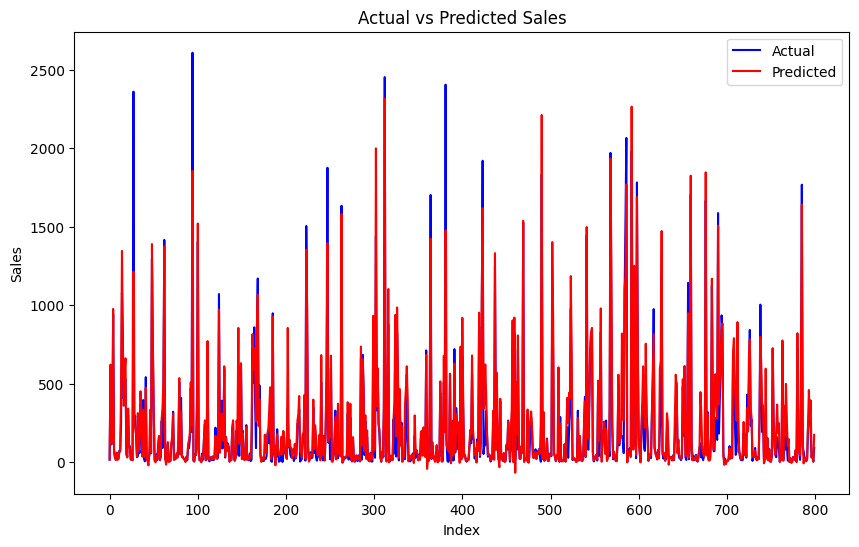

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred = model.predict(testX)

# Calculate MAE and RMSE
mae = mean_absolute_error(testy, y_pred)
rmse = mean_squared_error(testy, y_pred, squared=False)

# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(testy, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


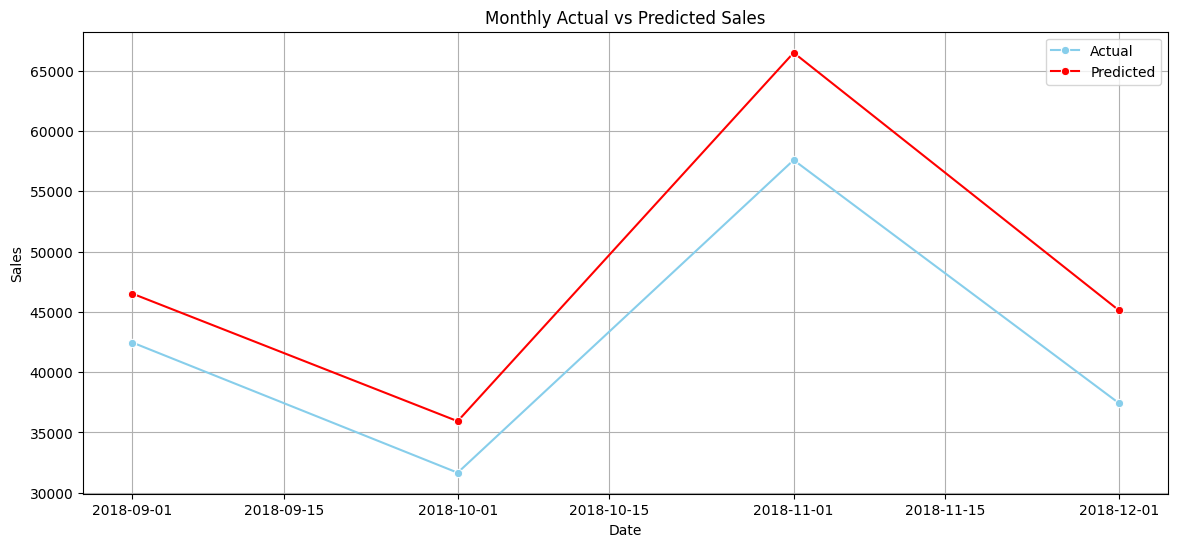

In [104]:
# Create a DataFrame for actual and predicted values, using 'test_data' to get the year and month
test_results = pd.DataFrame({
    'Actual': testy,
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month
})

# Group by 'year' and 'month' to aggregate actual and predicted log_sales
monthly_log_sales = test_results.groupby(['year', 'month']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Convert 'year' and 'month' into a proper date format for plotting
monthly_log_sales['date'] = pd.to_datetime(monthly_log_sales[['year', 'month']].assign(day=1))

# Plotting the monthly actual vs predicted log sales
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_log_sales, x='date', y='Actual', label='Actual', marker='o', color='skyblue')
sns.lineplot(data=monthly_log_sales, x='date', y='Predicted', label='Predicted', marker='o', color='red')

plt.title('Monthly Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

(70, 6)


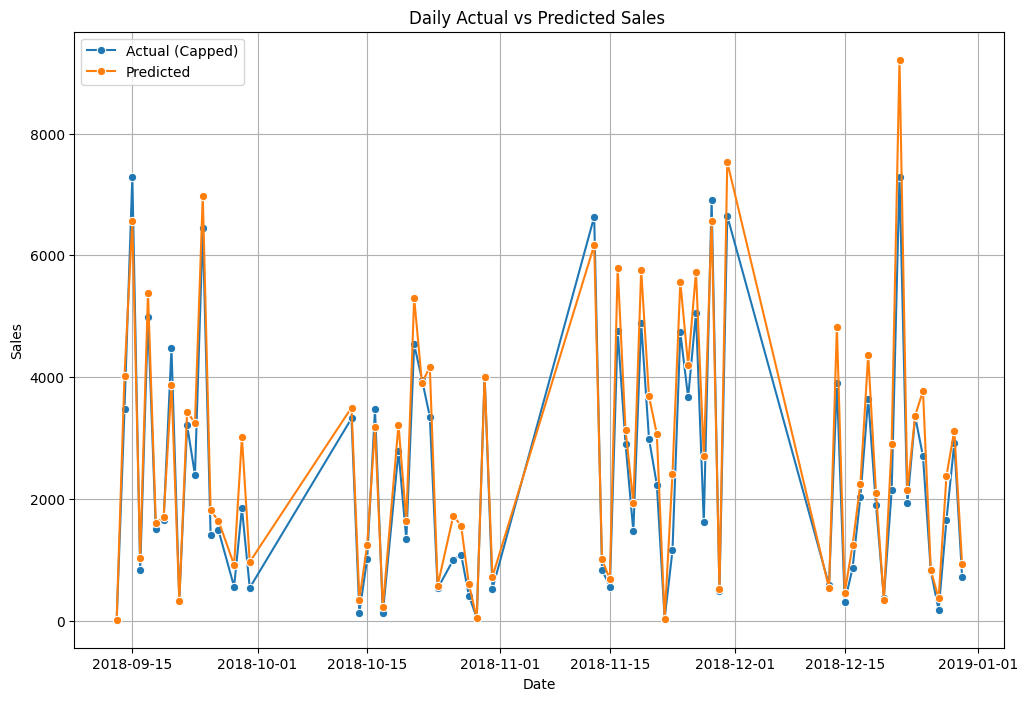

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred and test_data are already defined
# Create a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data['sales_$'],
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month,
    'day': test_data['order_date'].dt.day
})

# Group by year, month, and day, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Create a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

print(daily_sales.shape)

# Create a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting daily actual vs predicted sales
plt.figure(figsize=(12, 8))
sns.lineplot(data=daily_sales, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
sns.lineplot(data=daily_sales, x='date', y='Predicted', label='Predicted', marker='o')

plt.title('Daily Actual vs Predicted Sales ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


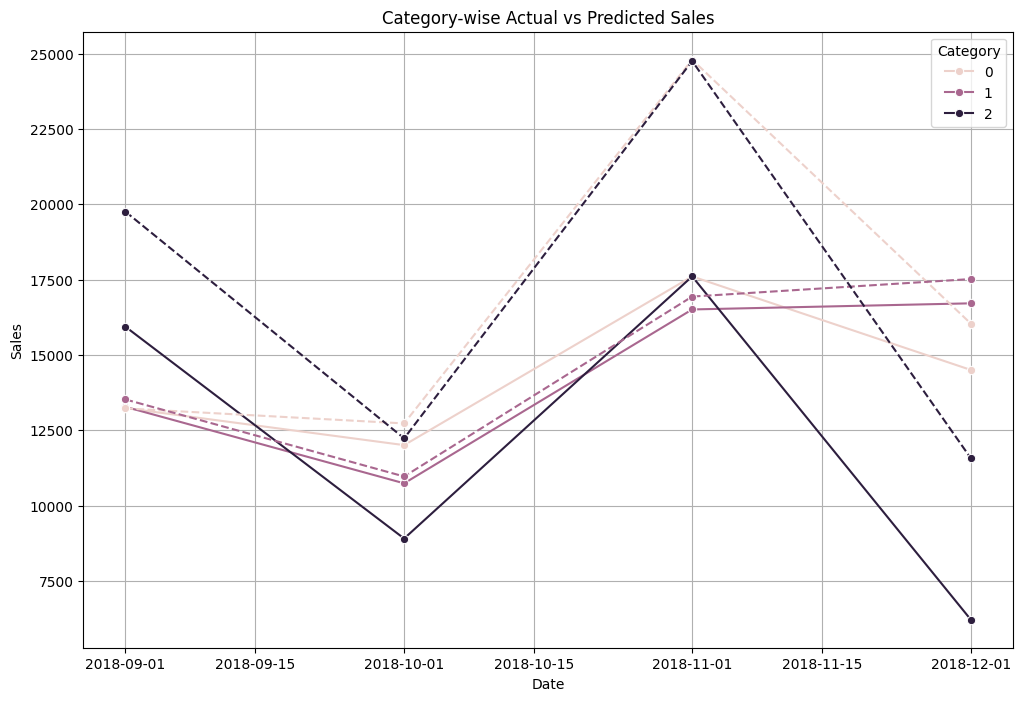

In [106]:
# Create a DataFrame with actual and predicted sales for each category
test_results = pd.DataFrame({
    'Actual': test_data['sales_$'],
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month,
    'day': test_data['order_date'].dt.day,
    'category': test_data['category']
})

# Group by category, year, and month, and sum the actual and predicted sales
category_sales = test_results.groupby(['category', 'year', 'month']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Create a capped version of Actual without changing the data scale
second_max_value = category_sales['Actual'].nlargest(2).iloc[-1]
category_sales['Actual_capped'] = category_sales['Actual'].clip(upper=second_max_value)

# Create a date column for plotting
category_sales['date'] = pd.to_datetime(category_sales[['year', 'month']].assign(day=1))

# Plotting category-wise actual vs predicted sales
plt.figure(figsize=(12, 8))

# Plot for Actual (Capped)
sns.lineplot(data=category_sales, x='date', y='Actual_capped', hue='category', marker='o', legend='full')

# Plot for Predicted
sns.lineplot(data=category_sales, x='date', y='Predicted', hue='category', marker='o', linestyle='--', legend=False)

plt.title('Category-wise Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

# Add legend for categories
plt.legend(title='Category')

plt.show()



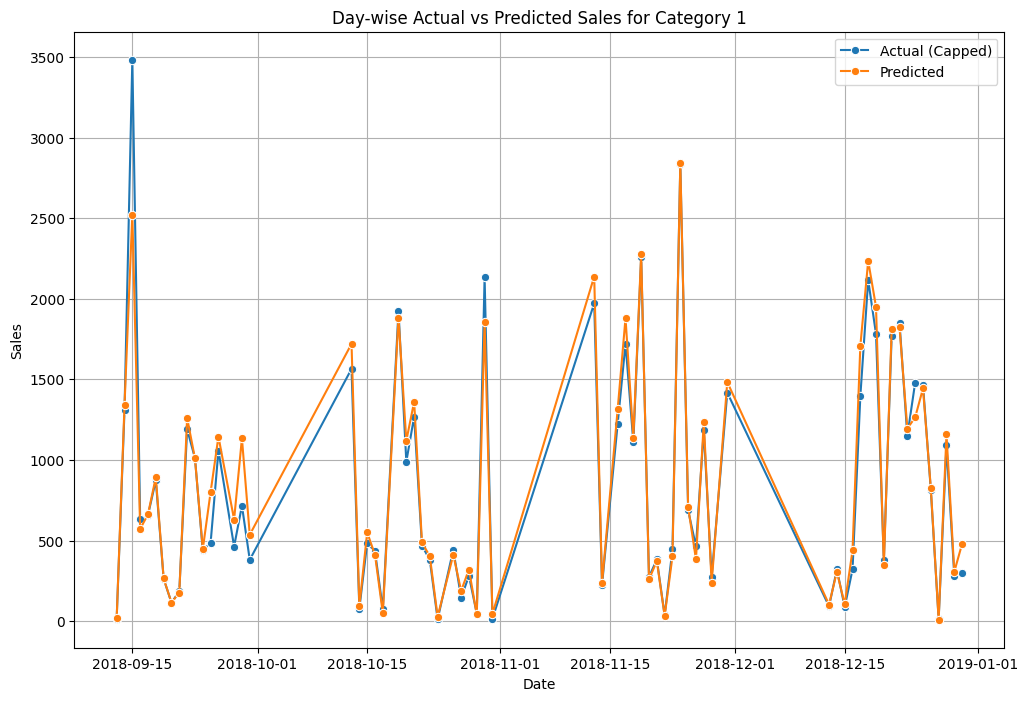

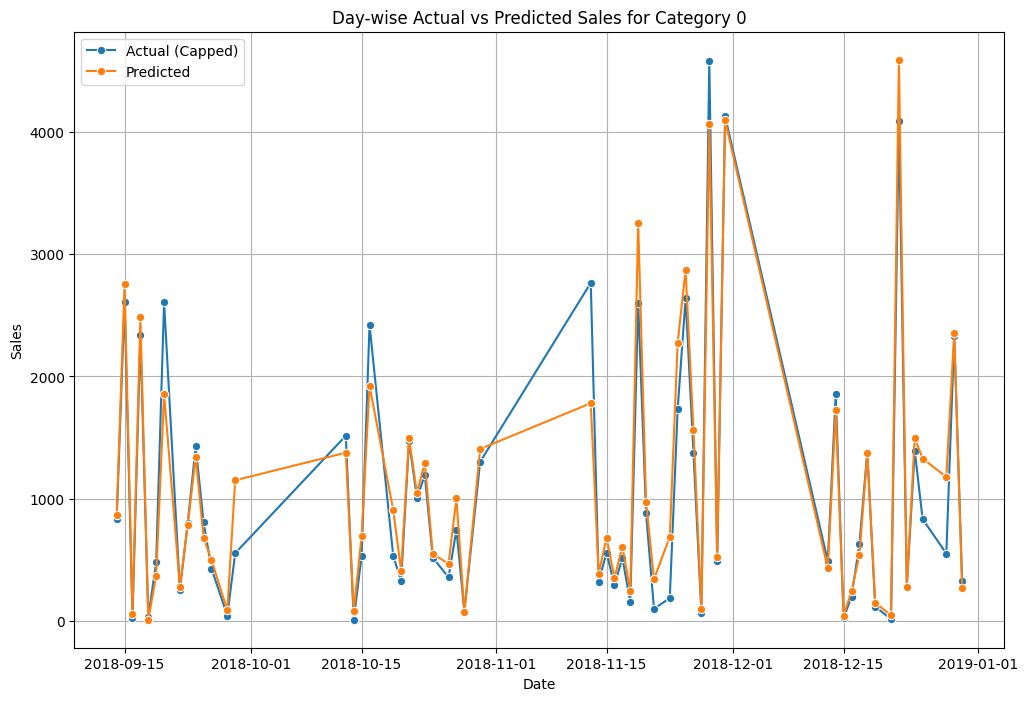

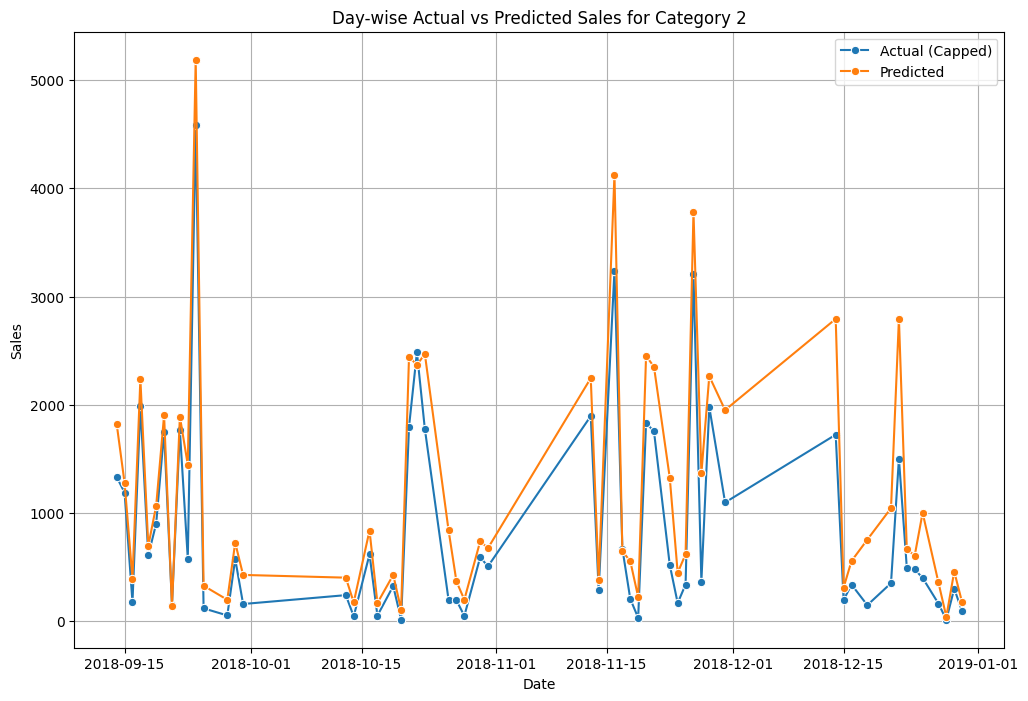

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred and test_data are already defined
# Create a DataFrame with daily actual and predicted sales
test_results = pd.DataFrame({
    'Actual': test_data['sales_$'],
    'Predicted': y_pred,
    'year': test_data['order_date'].dt.year,
    'month': test_data['order_date'].dt.month,
    'day': test_data['order_date'].dt.day,
    'category': test_data['category']  # Include category in the DataFrame
})

# Group by year, month, day, and category, and sum the actual and predicted sales
daily_sales = test_results.groupby(['year', 'month', 'day', 'category']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Create a capped version of Actual without changing the data scale
second_max_value = daily_sales['Actual'].nlargest(2).iloc[-1]
daily_sales['Actual_capped'] = daily_sales['Actual'].clip(upper=second_max_value)

# Create a date column for plotting
daily_sales['date'] = pd.to_datetime(daily_sales[['year', 'month', 'day']])

# Plotting day-wise actual vs predicted sales for each category
categories = daily_sales['category'].unique()

for category in categories:
    plt.figure(figsize=(12, 8))
    category_data = daily_sales[daily_sales['category'] == category]
    sns.lineplot(data=category_data, x='date', y='Actual_capped', label='Actual (Capped)', marker='o')
    sns.lineplot(data=category_data, x='date', y='Predicted', label='Predicted', marker='o')

    plt.title(f'Day-wise Actual vs Predicted Sales for Category {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()


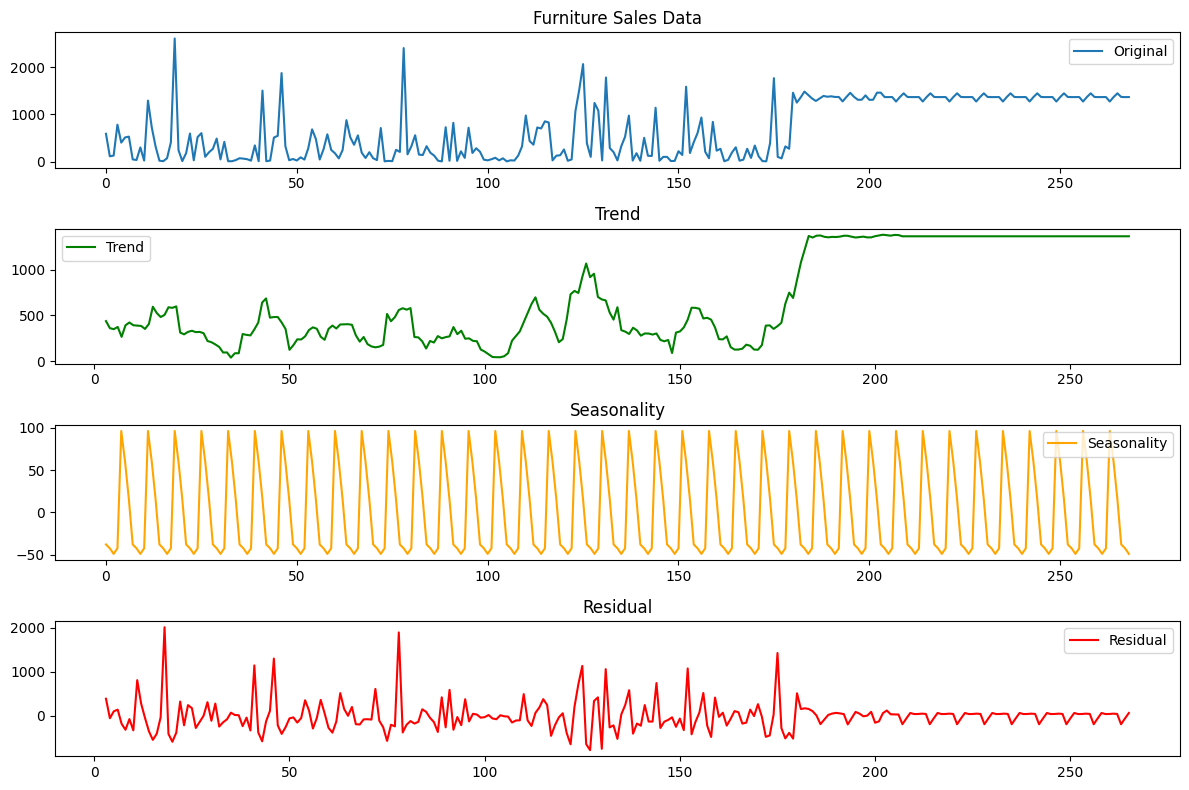

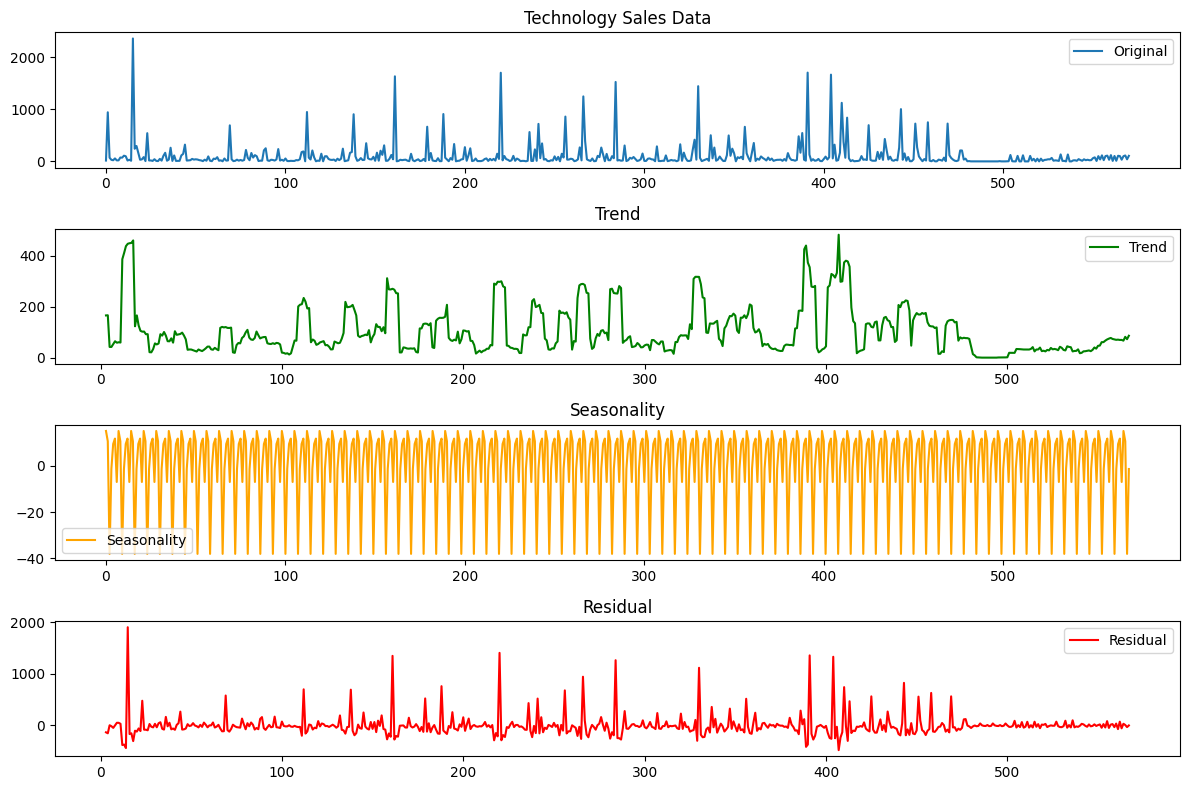

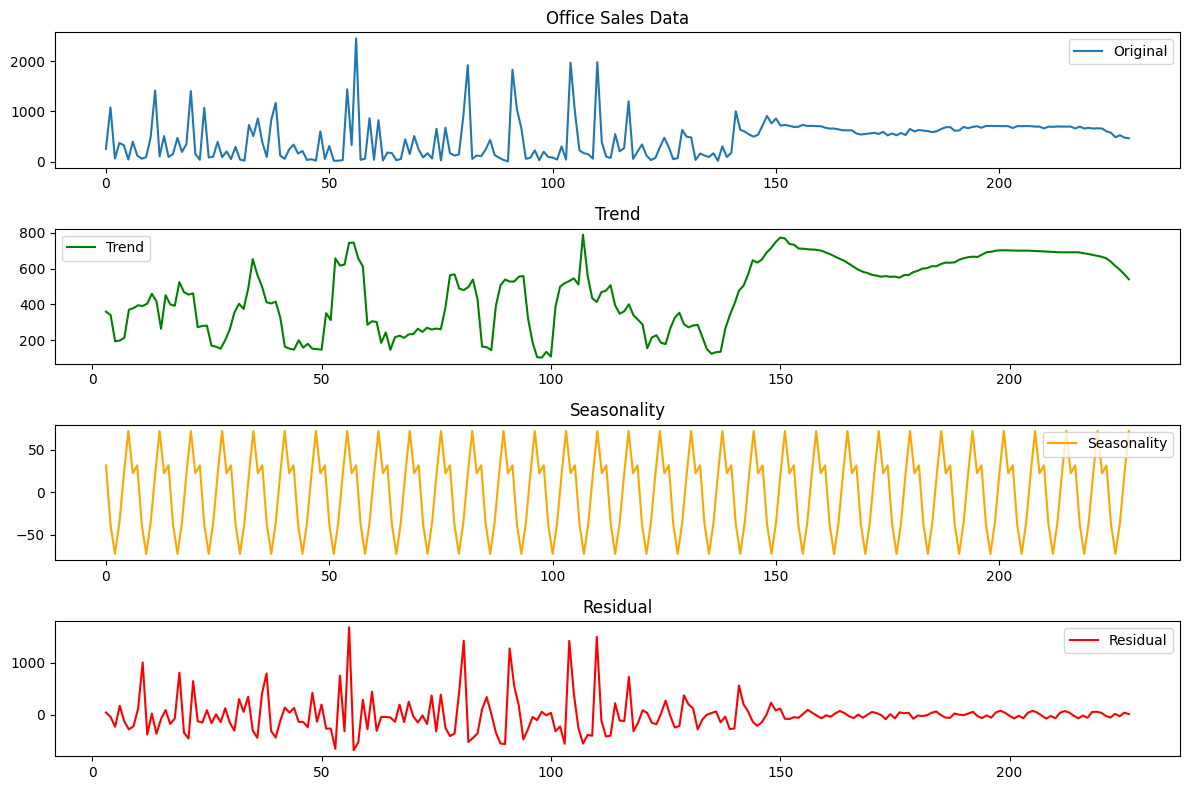

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to decompose and plot seasonality, trend, and residuals
def decompose_and_plot(df, category_name, model_type='additive', column='sales_$', freq=7):


    # Drop missing values (if any) for decomposition
    df_clean = df[[column]].dropna()

    # Decompose the time series
    decomposition = seasonal_decompose(df_clean, model=model_type, period=freq)

    # Plot the components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(df_clean, label='Original')
    plt.title(f'{category_name} Sales Data')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='green')
    plt.title('Trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
    plt.title('Seasonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual', color='red')
    plt.title('Residual')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Example usage for Furniture predictions
decompose_and_plot(furniture_test_df, "Furniture", model_type='additive', column='sales_$', freq=7)

# Example usage for Technology predictions
decompose_and_plot(technology_test_df, "Technology", model_type='additive', column='sales_$', freq=7)

# Example usage for Office predictions
decompose_and_plot(office_test_df, "Office", model_type='additive', column='sales_$', freq=7)
